<a href="https://colab.research.google.com/github/raulbenitez/DEEPCARDIO/blob/master/NextFrame/nextFrame200_performanceAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn
from skimage.filters import threshold_otsu

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
seq = keras.models.load_model('drive/My Drive/tfm/DEEPCARDIO_drive/NextFrame/200epochModel.h5')
seq

In [81]:
# UTIL FUNCTIONS

def generate_movies(n_samples=1200, n_frames=15, speed=1, noise=0.1):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t*speed
                y_shift = ystart + directiony * t*speed
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * noise)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies


def row_n_imageshow(imgs, titles=None):
  n = len(imgs)
  fig = plt.figure(figsize=(5*n, 5))

  for i, img in enumerate(imgs):
    ax = fig.add_subplot(1, n, i+1)
    if titles and len(titles) > i and titles[i]:
      ax.text(**titles[i])
    plt.imshow(img)


def performance_evaluation(noisy_track, shifted_track, pred_track, title='', plot=True, n_decimals=4, binarize_threshold=0.5):
  disc_pred_track = (pred_track > binarize_threshold).astype(float)
  resDF = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1']).astype(float)

  for i in range(min(len(pred_track), len(noisy_track))):
    disc_shifted_frame = (shifted_track[i,::,::,0]>binarize_threshold)
    pixel_performance = np.logical_not(np.logical_xor(disc_pred_track[i,::,::,0], disc_shifted_frame)).astype(float)
    accuracy = round(pixel_performance.sum()/pixel_performance.size, n_decimals)
    # index -> reality, columns -> prediction
    confusionDF = pd.DataFrame(confusion_matrix(disc_shifted_frame.astype(float).flatten(), disc_pred_track[i,::,::,0].flatten()), index=[0,1], columns=[0,1])
    precision = round(confusionDF.loc[1, 1] / (confusionDF.loc[1, 1] + confusionDF.loc[0, 1]), n_decimals)
    recall = round(confusionDF.loc[1, 1] / (confusionDF.loc[1, 1] + confusionDF.loc[1, 0]), n_decimals)
    f1 = round(2 * (precision*recall)/(precision+recall), n_decimals)
    resDF.loc[i, :] = [accuracy, precision, recall, f1]

    if plot:
      txts = [{'x': 1, 'y': 3, 's':f'{title}Predictions !', 'fontsize':20, 'color':'w'},
            {'x': 1, 'y': 3, 's':f'Binary Pred ({round(binarize_threshold,2)}) !', 'fontsize':20, 'color':'w'},
            {'x': 1, 'y': 3, 's':'Ground truth (shifted)', 'fontsize':20},
            {'x': 1, 'y': 3, 's':'Original frame', 'fontsize':20},
            {'x': 1, 'y': 3, 's':f'Accuracy {accuracy}, f1: {f1}\nprecision: {precision}, recall: {recall}', 'fontsize':10}]
      row_n_imageshow([pred_track[i, ::, ::, 0],
                      disc_pred_track[i, ::, ::, 0], 
                      (shifted_track[i,::,::,0]>binarize_threshold).astype(float),
                      noisy_track[i,::,::,0],
                      pixel_performance], titles=txts)
    
  return resDF

,accuracy,precision,recall,f1
0,0.9862,0.9348,0.6935,0.7963


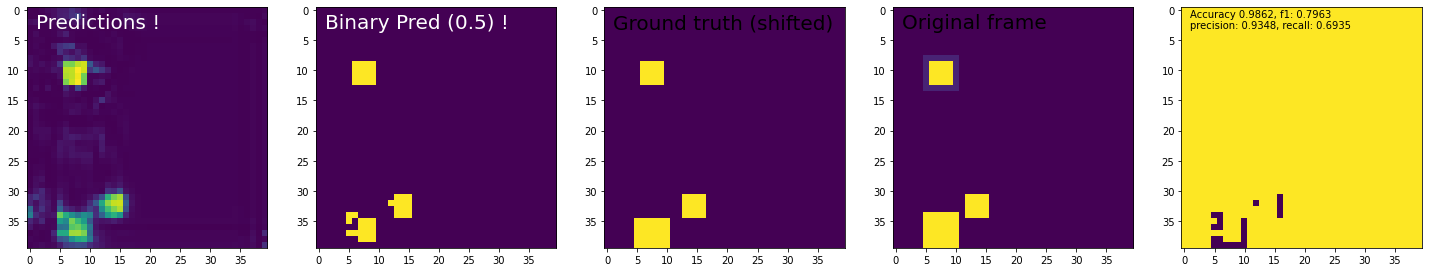

In [ ]:
noisy15, shifted15 = generate_movies(n_samples=1, n_frames=15)
pred15 = seq.predict(noisy15)
performance_evaluation(noisy15[0,-1:], shifted15[0,-1:], pred15[0,-1:], binarize_threshold=0.5)

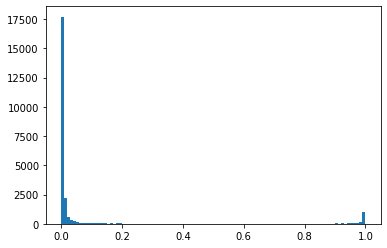

In [ ]:
plt.hist(pred15.flatten(), bins=100)
plt.show()

In [ ]:
threshold_otsu(pred15)

0.47072053

In [ ]:
noisy, shifted = generate_movies(n_samples=1, n_frames=15)
pred = seq.predict(noisy)
df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=False, binarize_threshold=0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


# 1 - 15 frames for prediction, mean of 5 executions - performance metric evaluation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


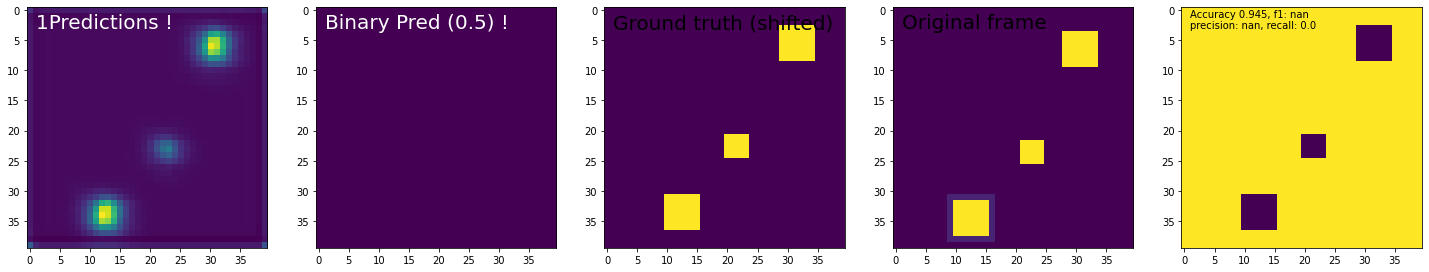

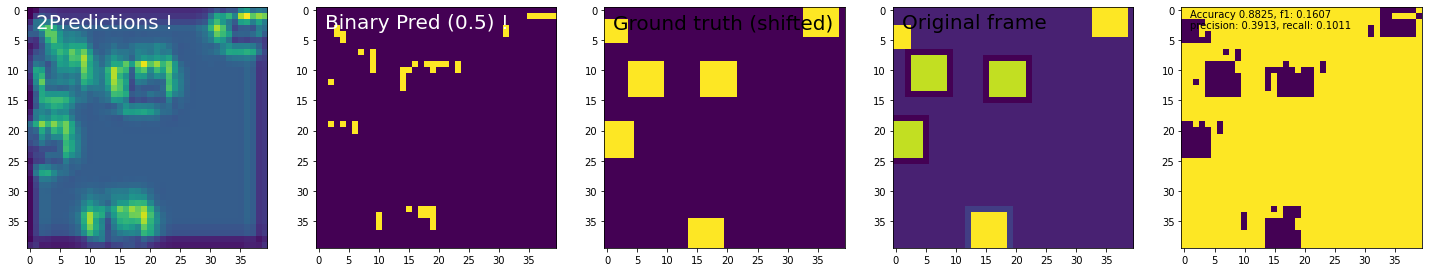

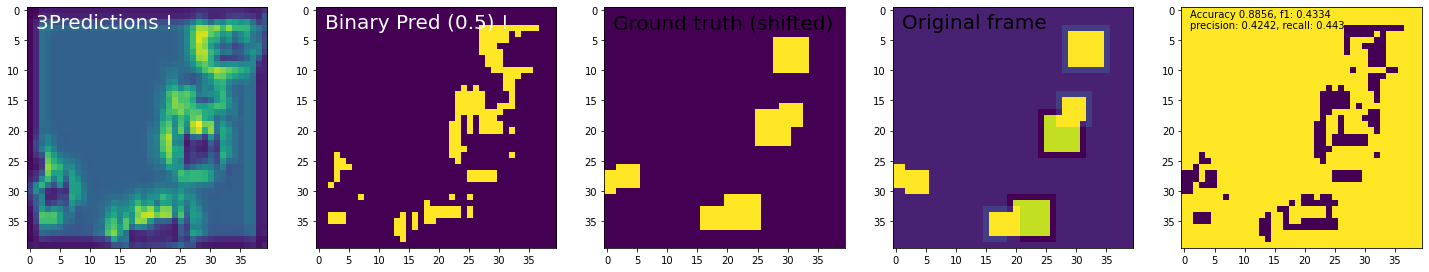

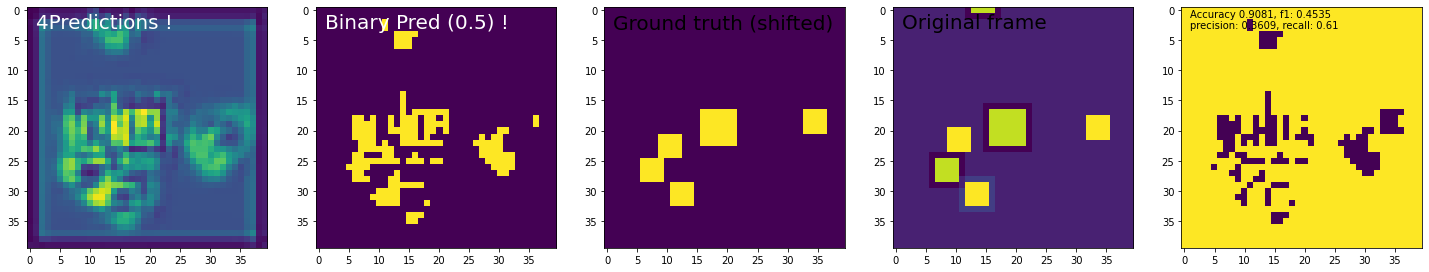

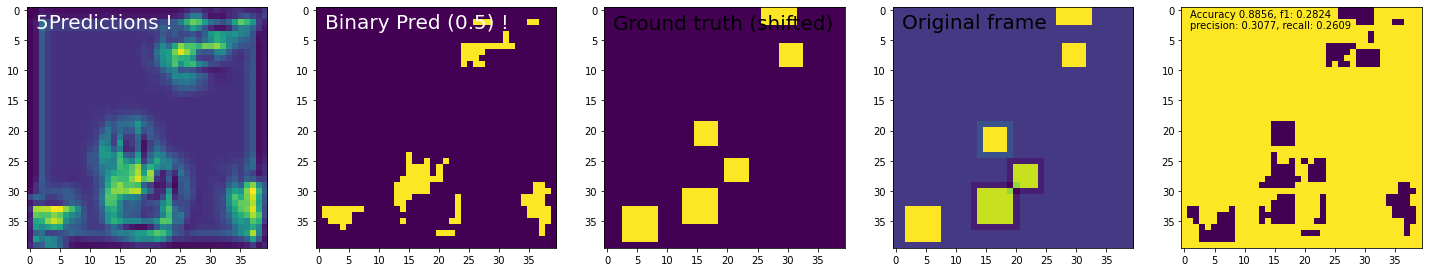

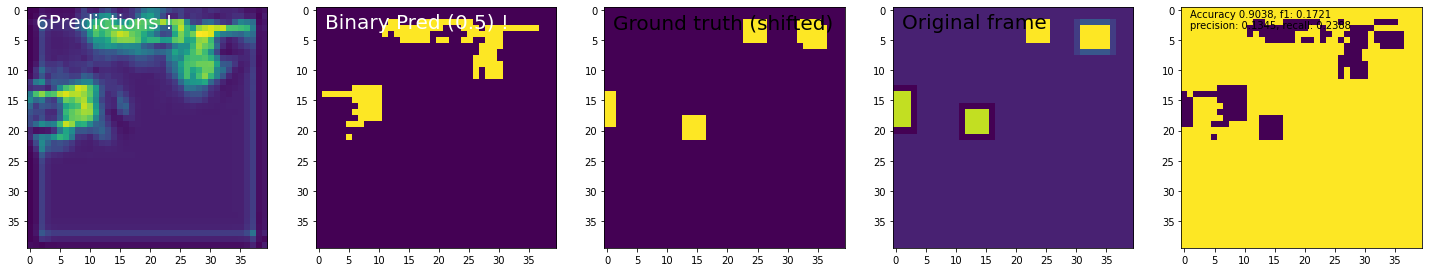

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


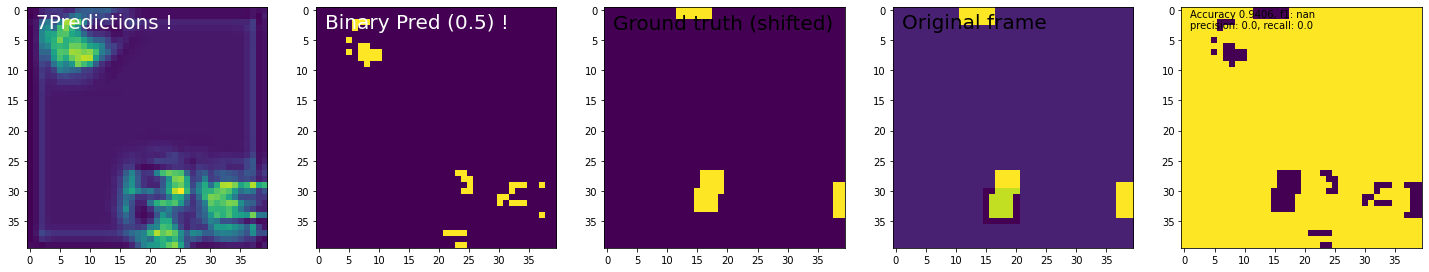

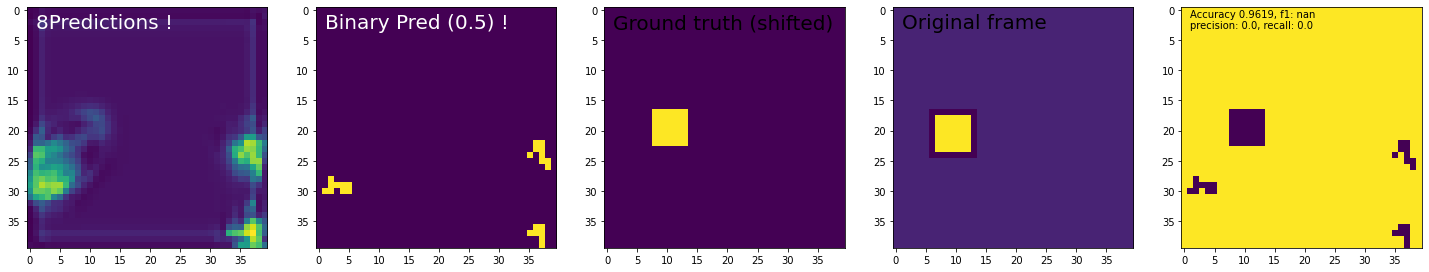

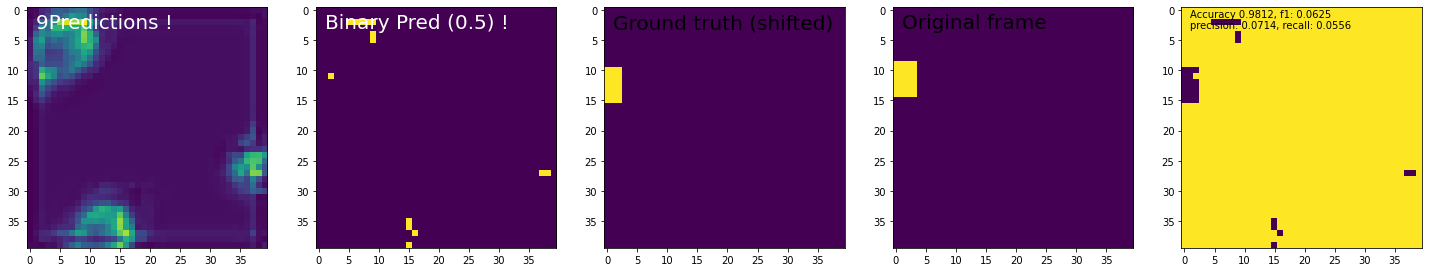

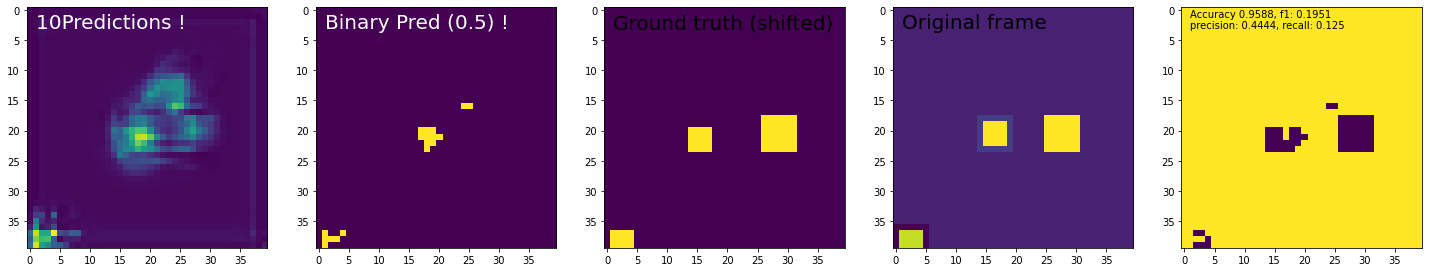

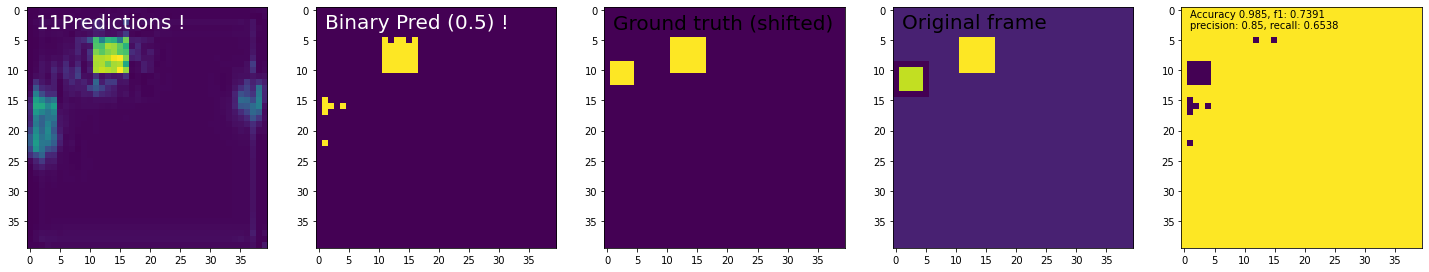

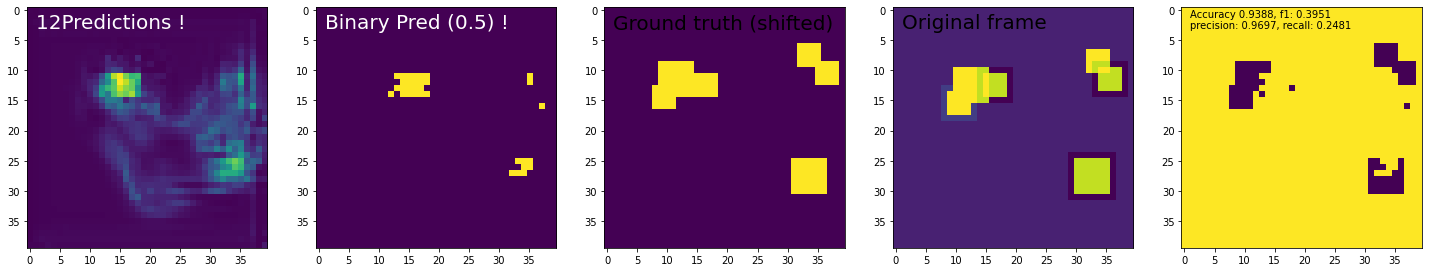

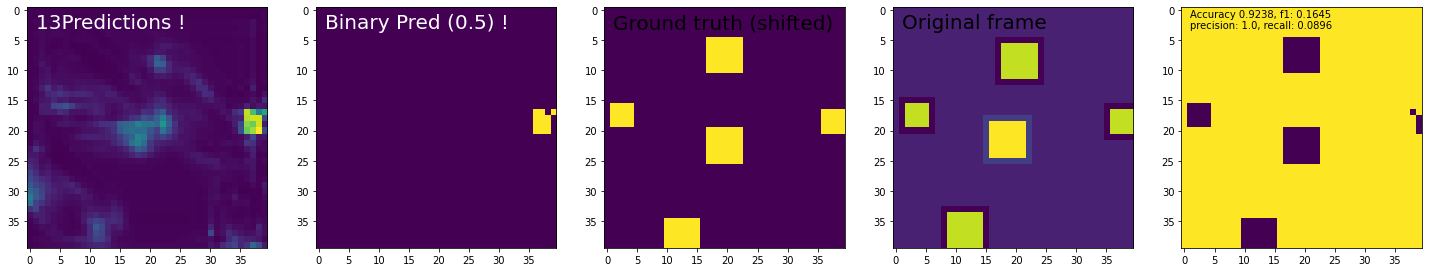

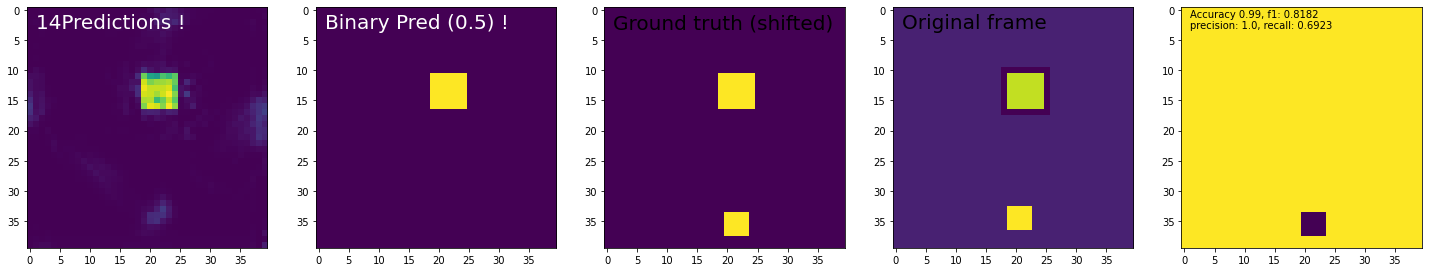

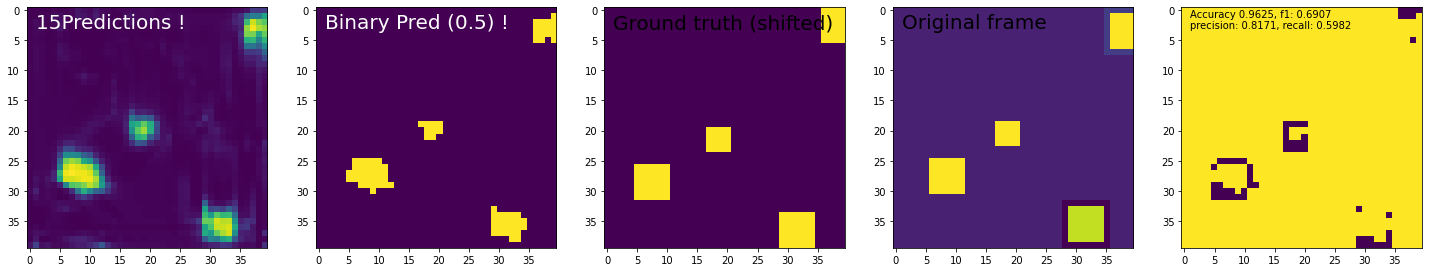

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


,accuracy,precision,recall,f1
n_frames,,,,
1,0.93750,NaN,0.00000,NaN
2,0.91612,0.449880,0.21324,0.283820
3,0.90300,0.334100,0.37758,0.351680
4,0.89998,0.352540,0.51072,0.409240
5,0.91036,0.380160,0.35274,0.365620
6,0.88662,0.240860,0.24972,0.237160
7,0.92010,0.197900,0.09856,0.213533
8,0.95614,0.221500,0.15450,0.455050
9,0.94760,0.243200,0.11404,0.191050


In [ ]:
dfList = []

for len_movie in range(1, 16):
  for execIdx in range(5):
    # print(len_movie, execIdx)
    noisy, shifted = generate_movies(n_samples=1, n_frames=len_movie)
    pred = seq.predict(noisy)
    df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], title=str(len_movie), binarize_threshold=0.5, plot=execIdx==0)
    if execIdx==0:
      plt.show()
    df.loc[:, 'n_frames'] = len_movie
    df.loc[:, 'idx'] = execIdx
    dfList.append(df)

perfDF = pd.concat(dfList)
perfDF.groupby('n_frames')['accuracy', 'precision', 'recall', 'f1'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


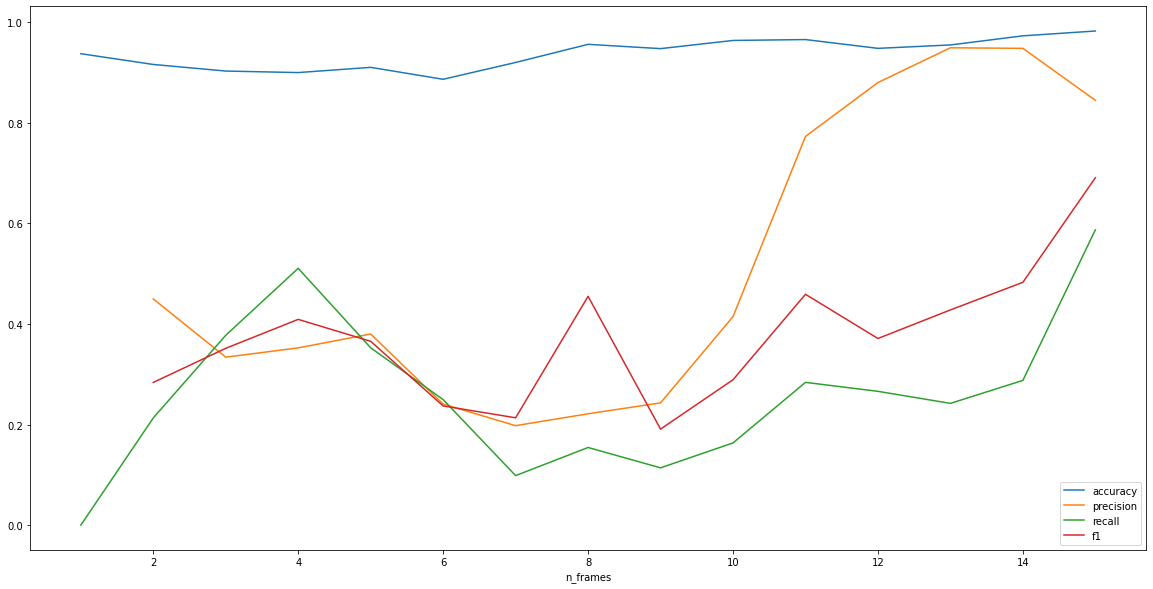

In [ ]:
perfDF.groupby('n_frames')['accuracy', 'precision', 'recall', 'f1'].mean().plot(figsize=(20, 10))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


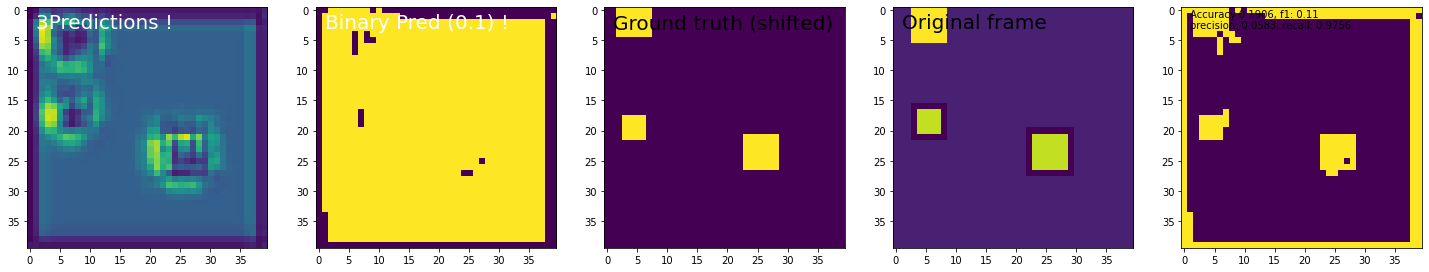

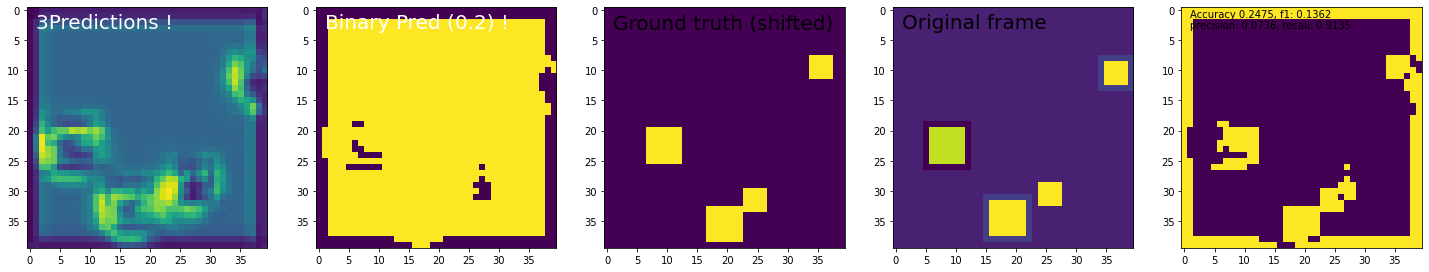

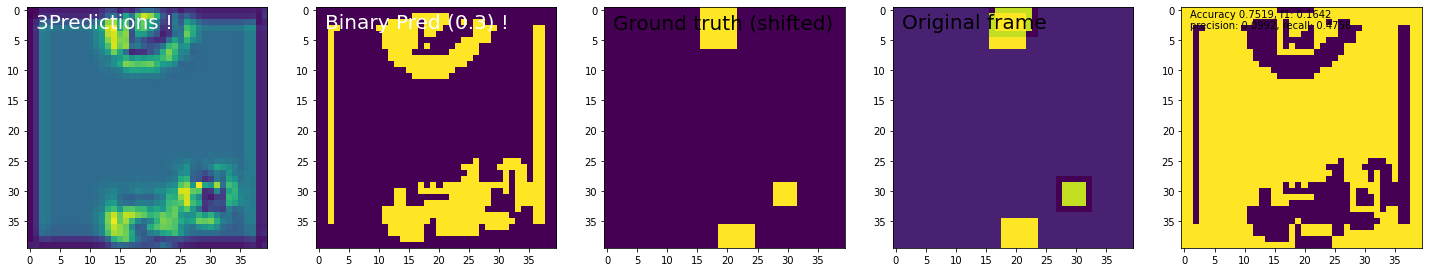

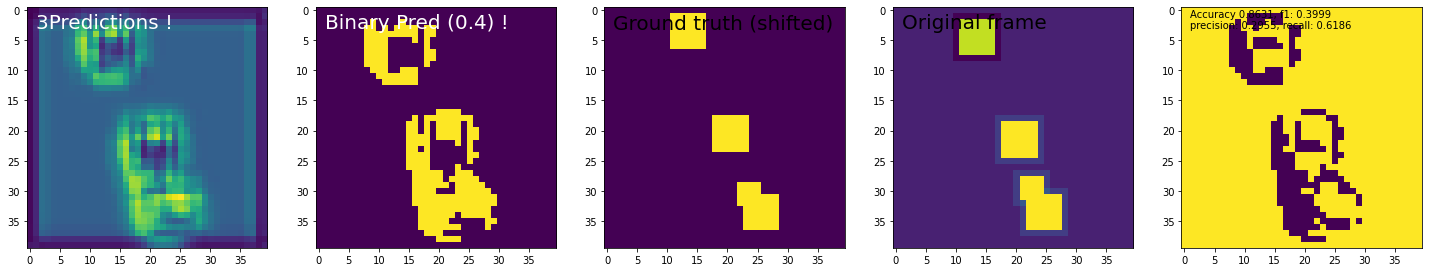

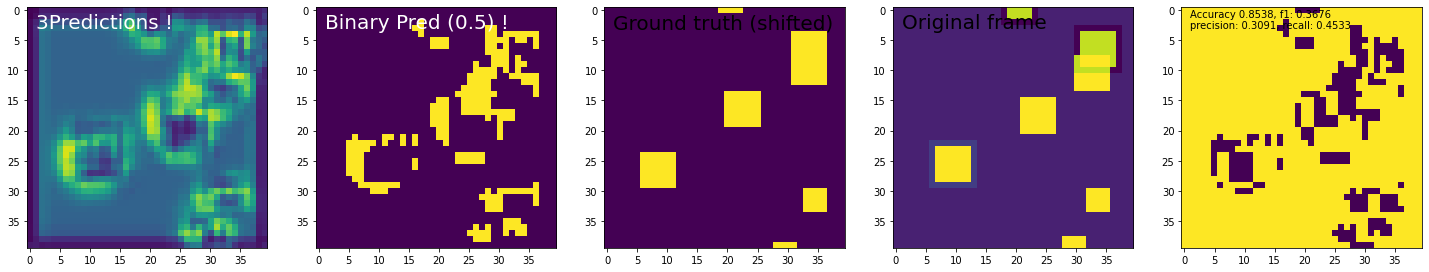

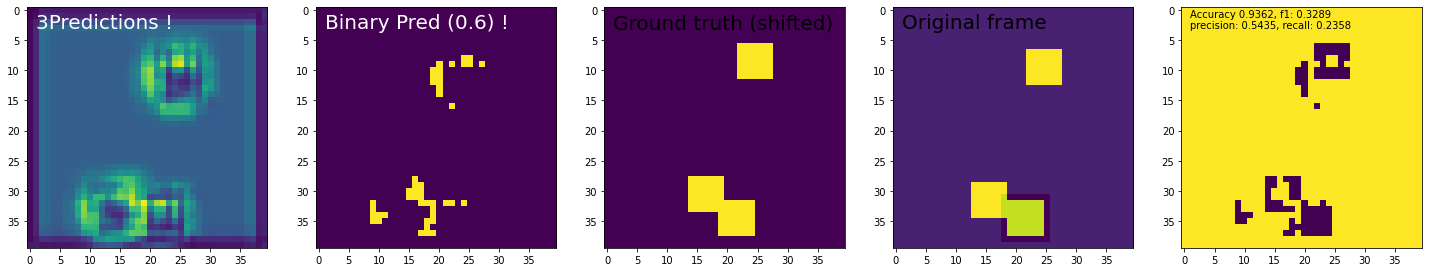

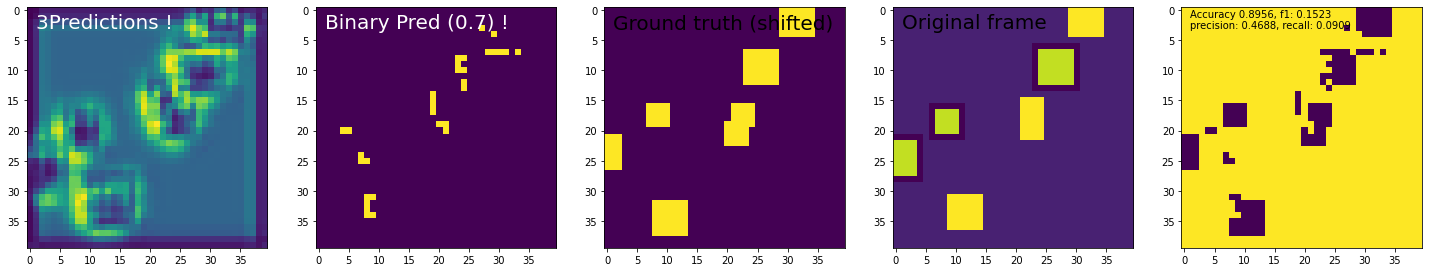

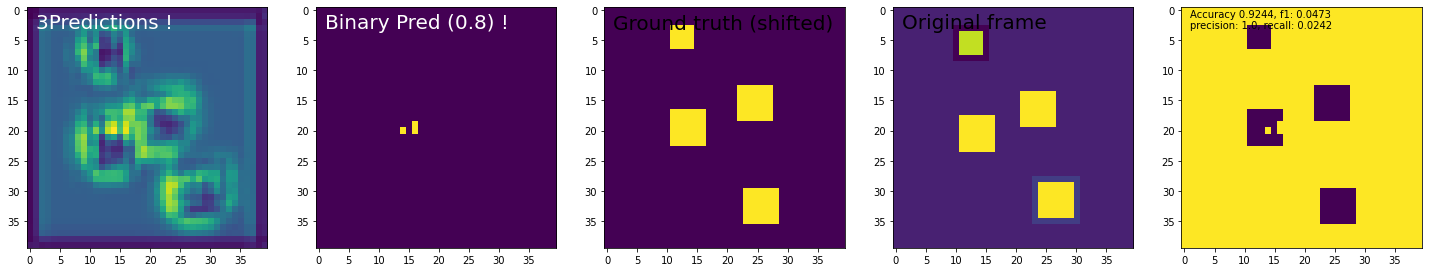

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


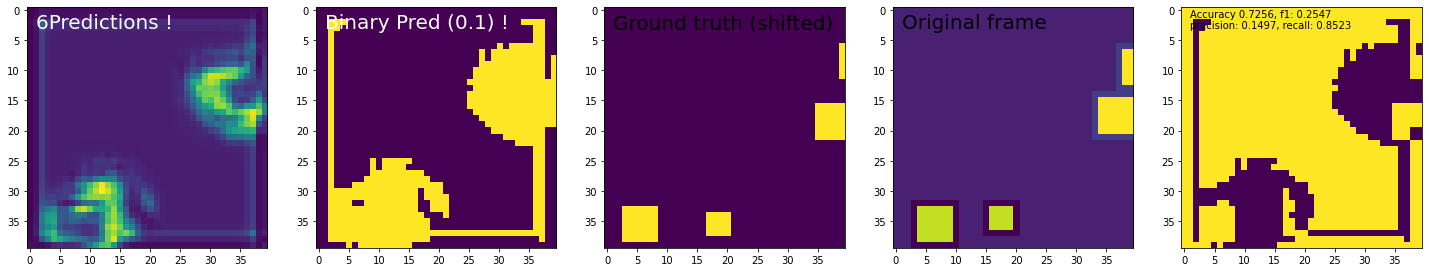

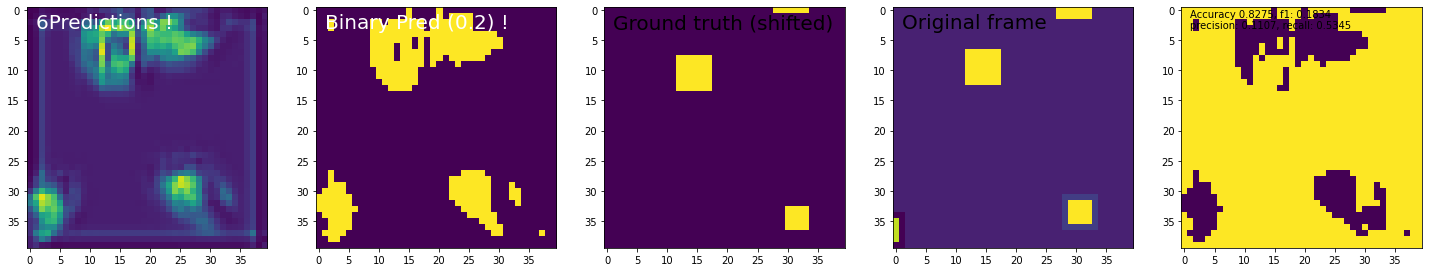

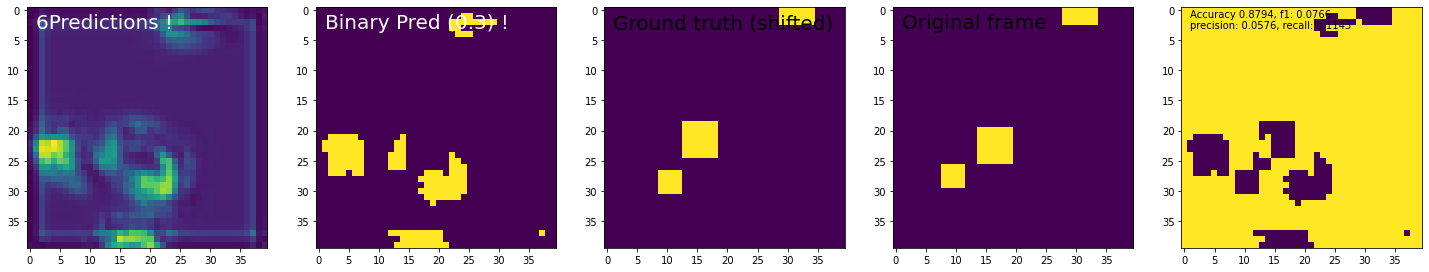

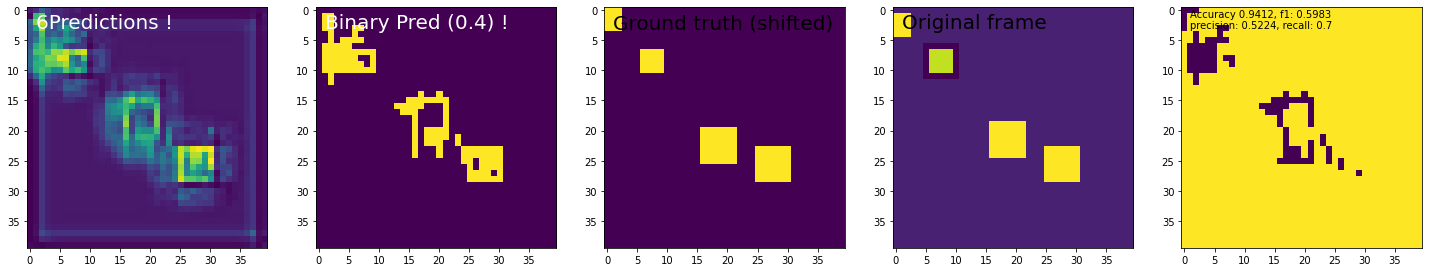

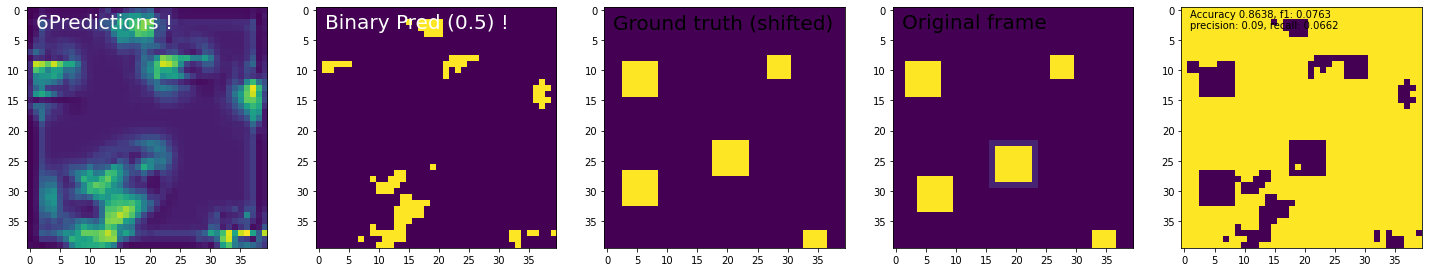

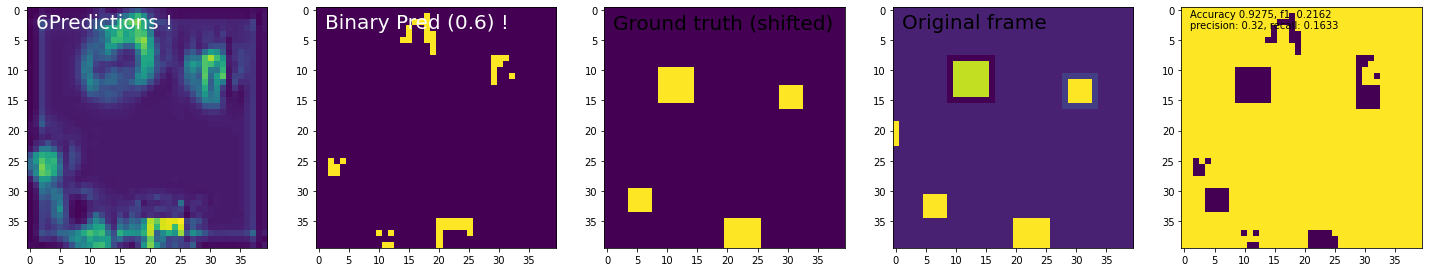

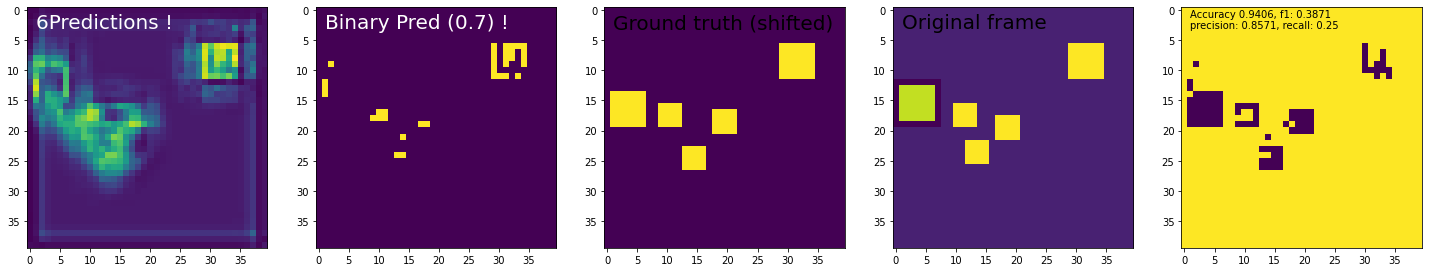

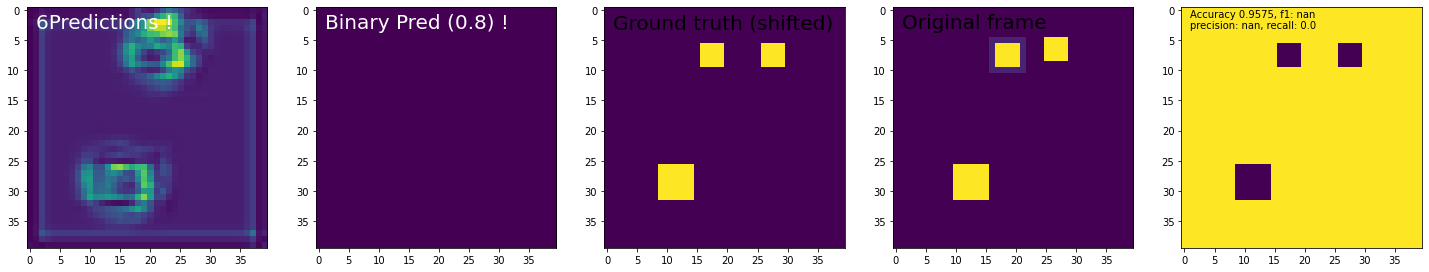

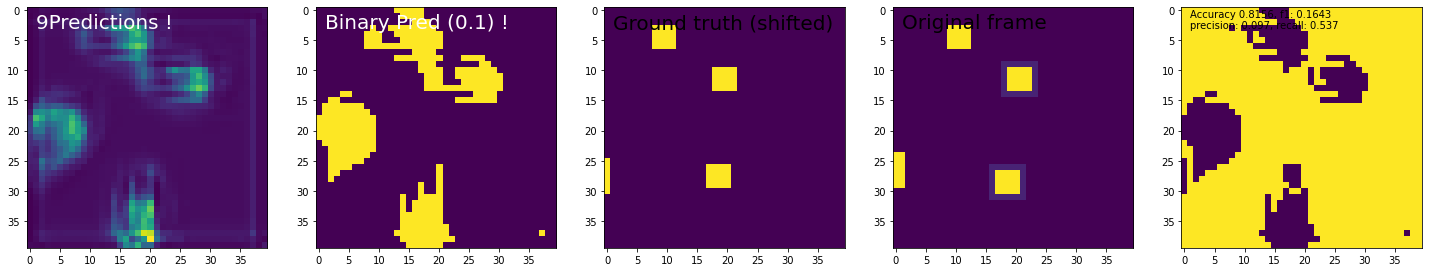

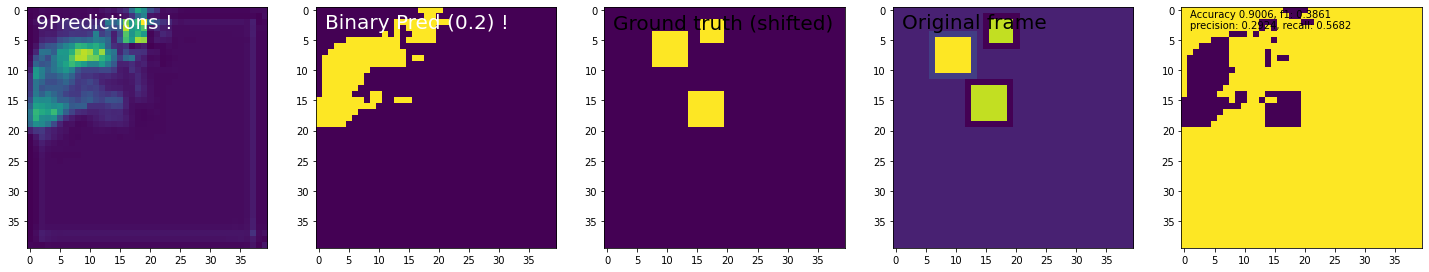

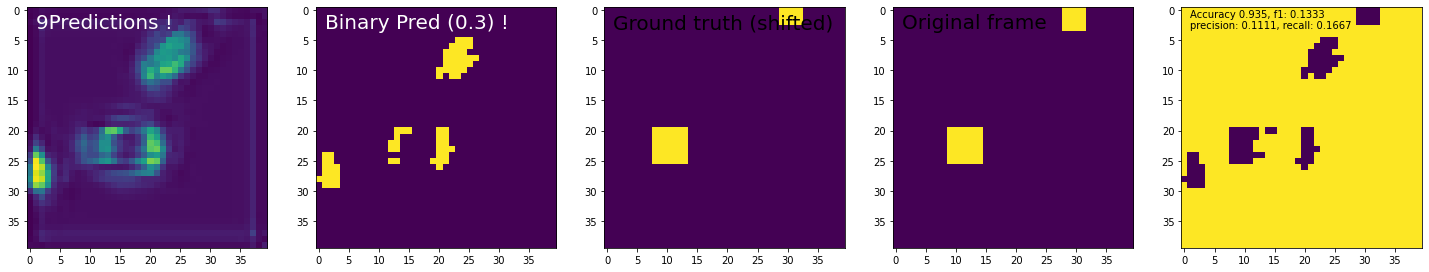

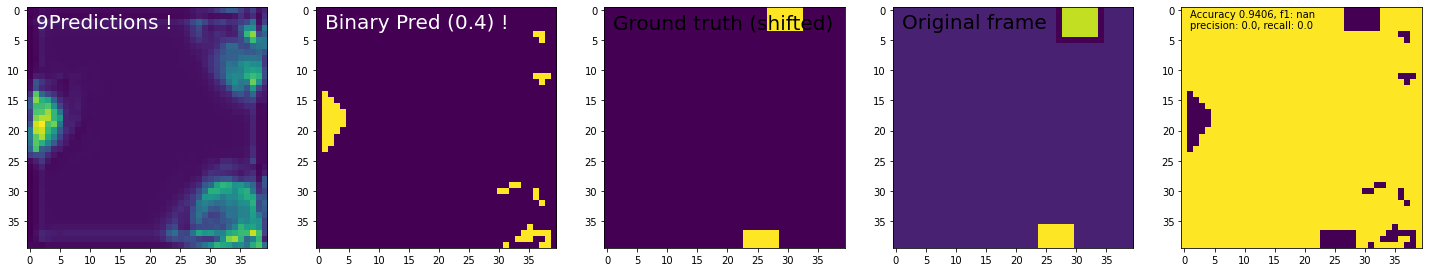

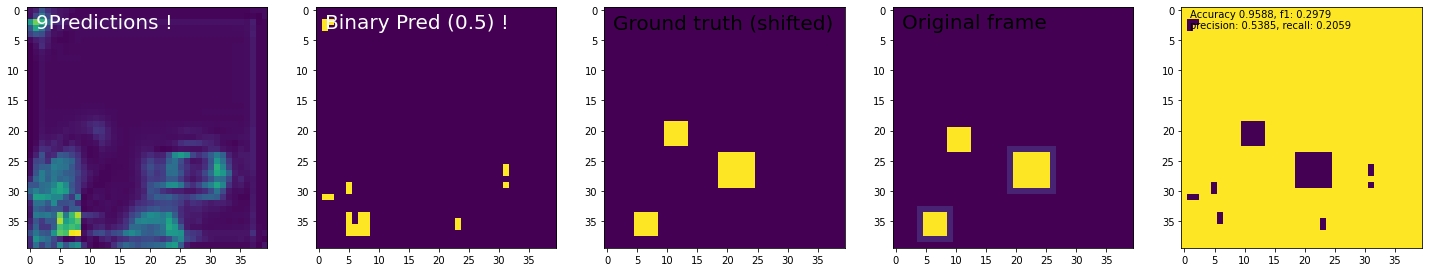

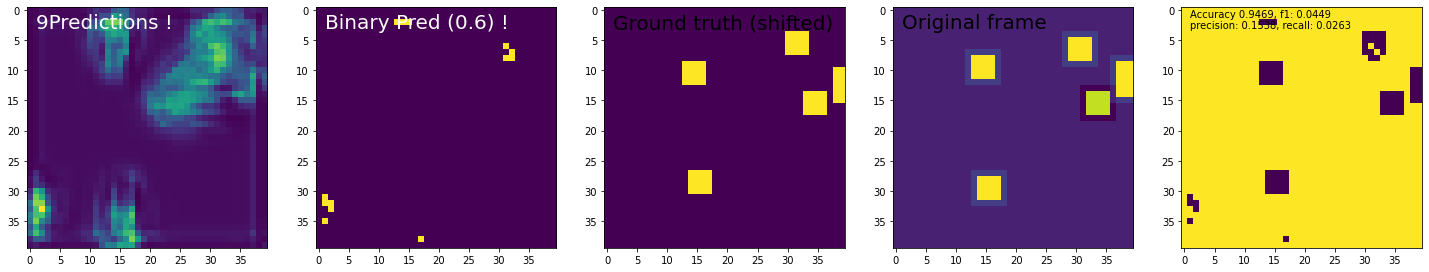

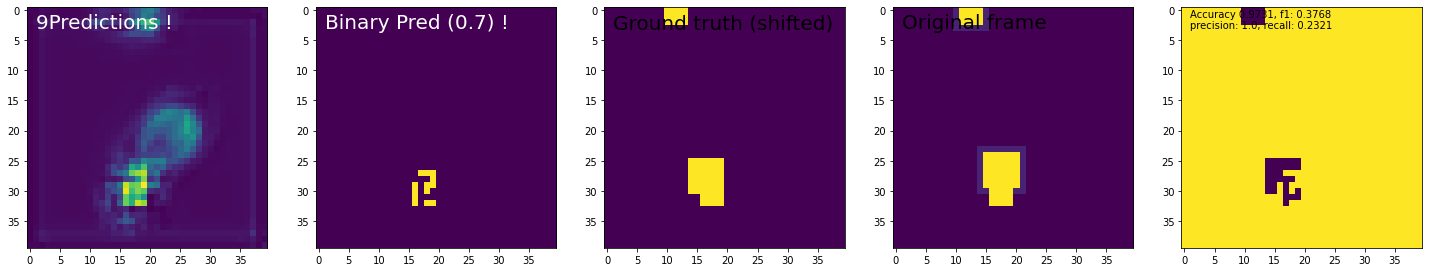

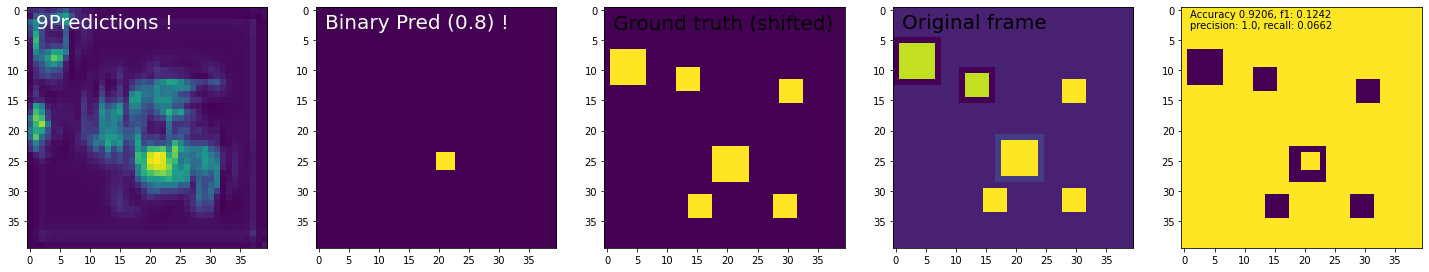

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


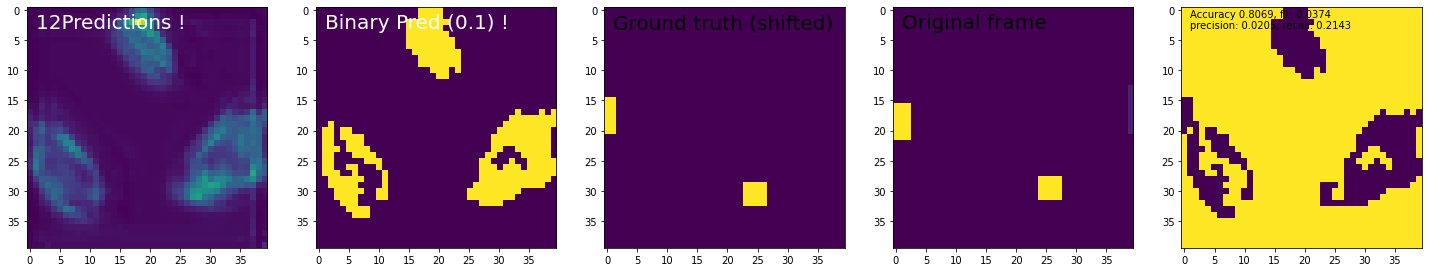

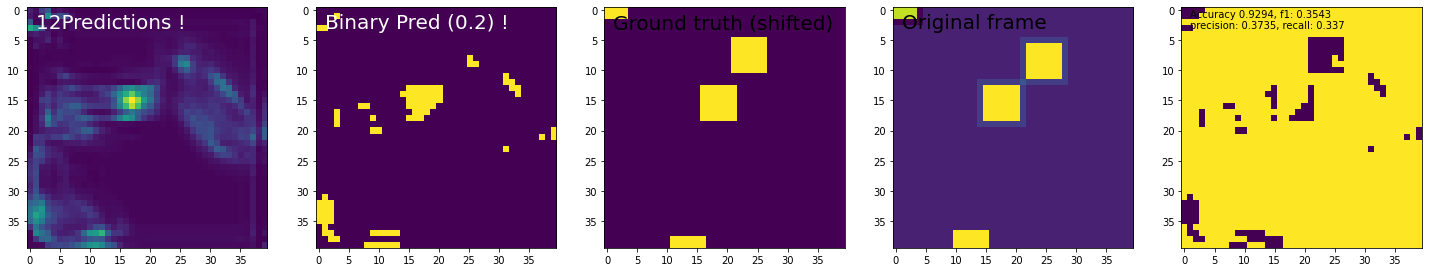

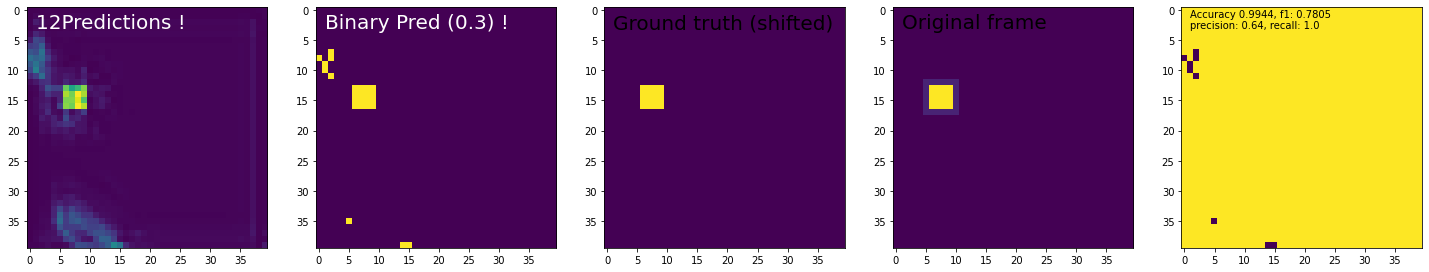

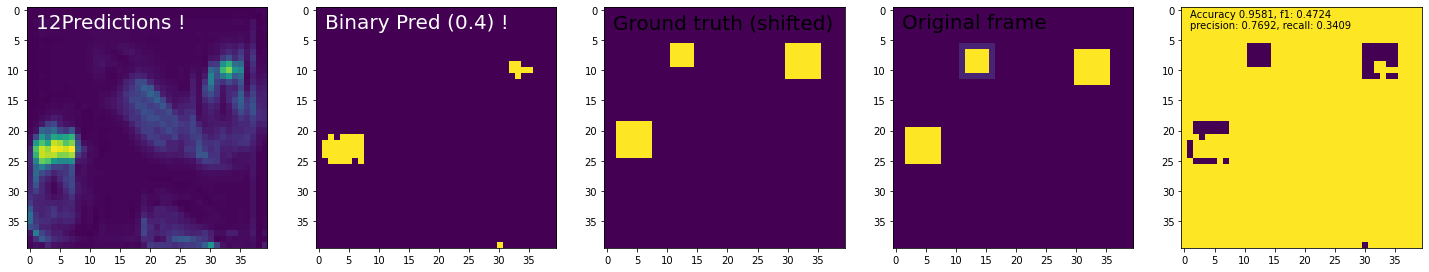

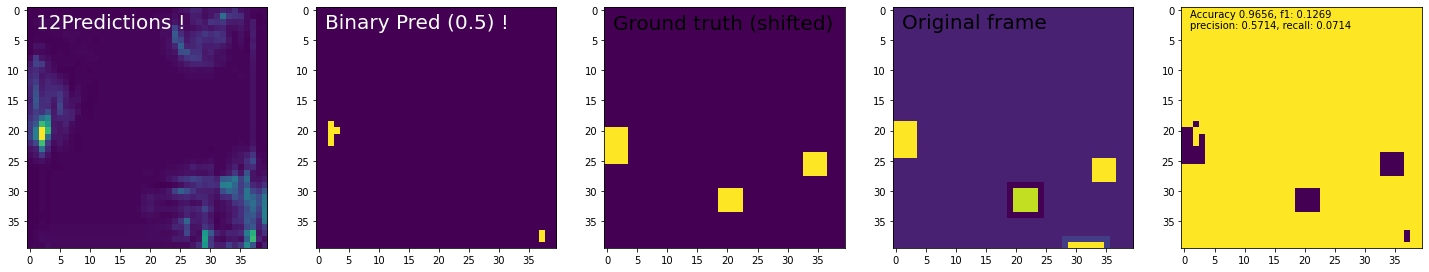

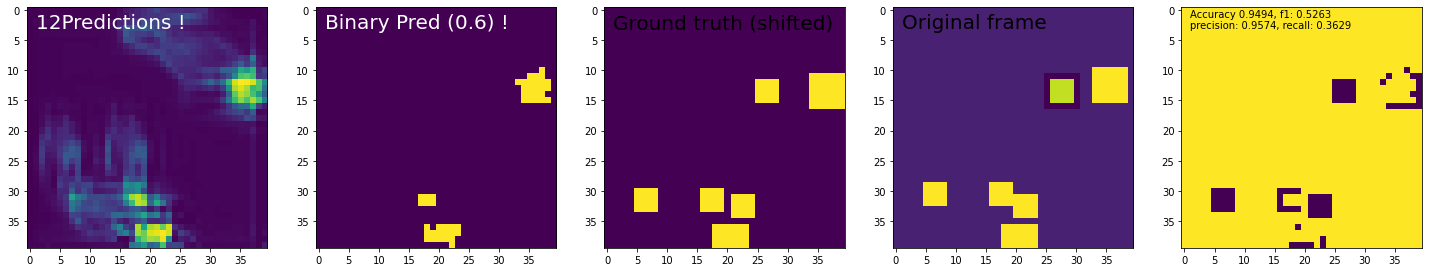

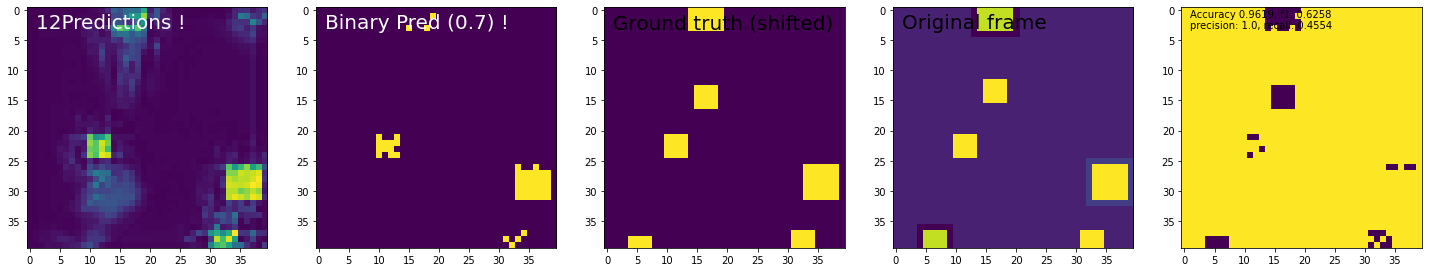

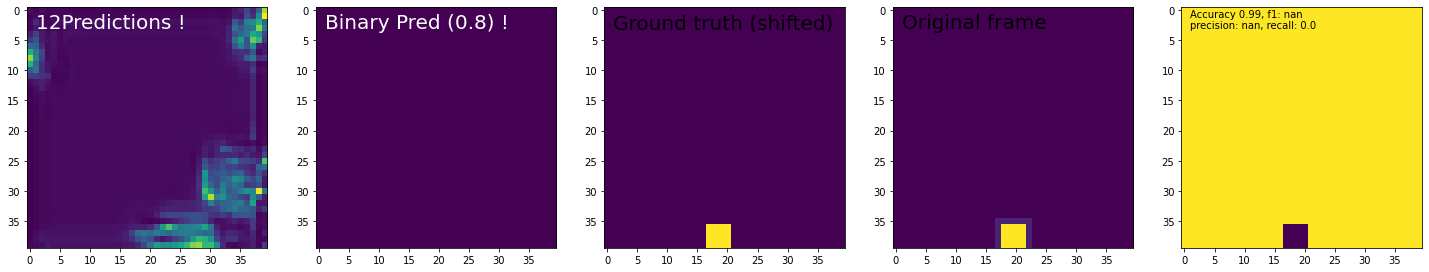

Error with len 14, bin_thr 0.6, execIdx 1
shape noisy (1, 14, 40, 40, 1), shape shifted (1, 14, 40, 40, 1) and shape pred (1, 14, 40, 40, 1)


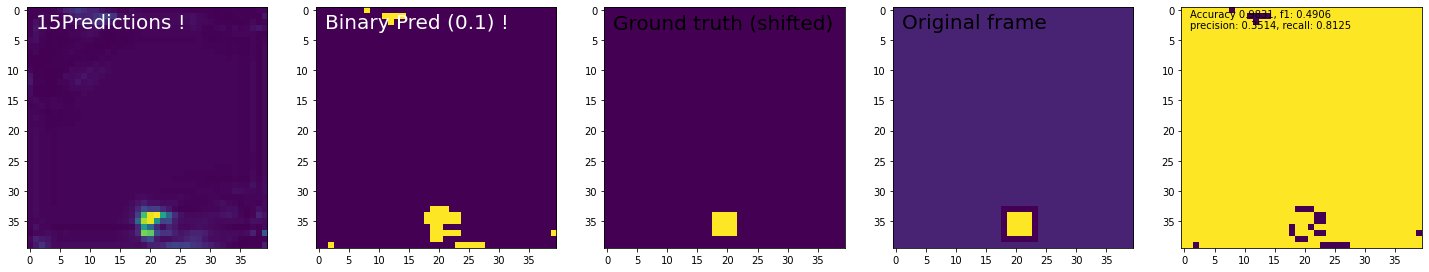

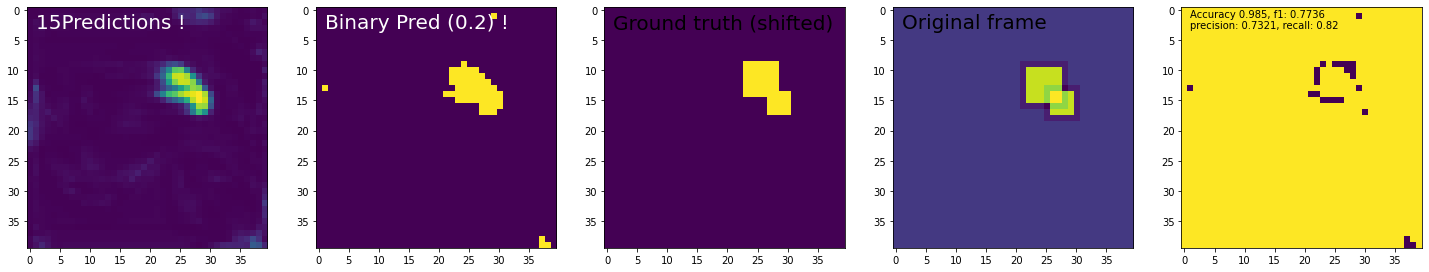

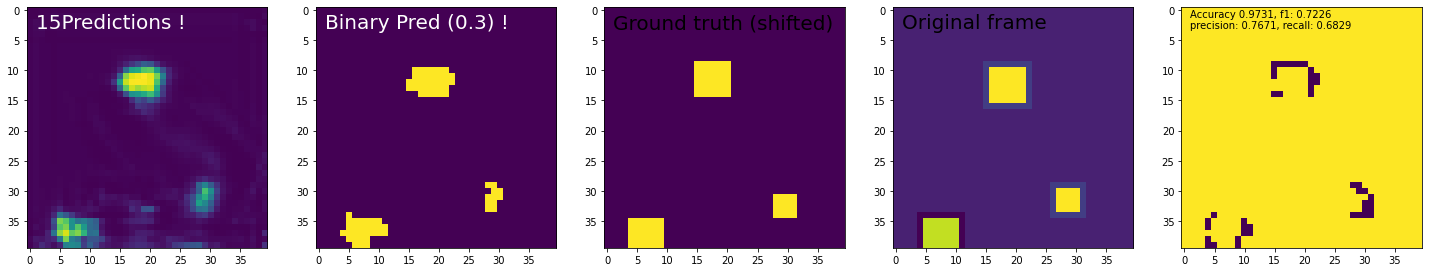

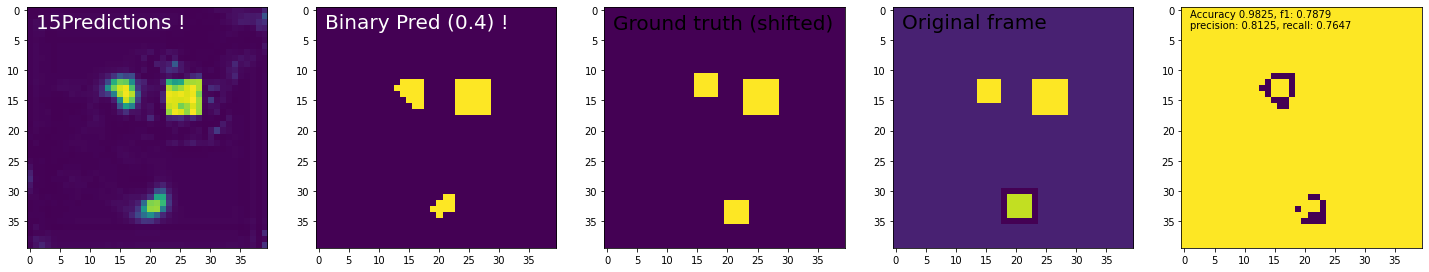

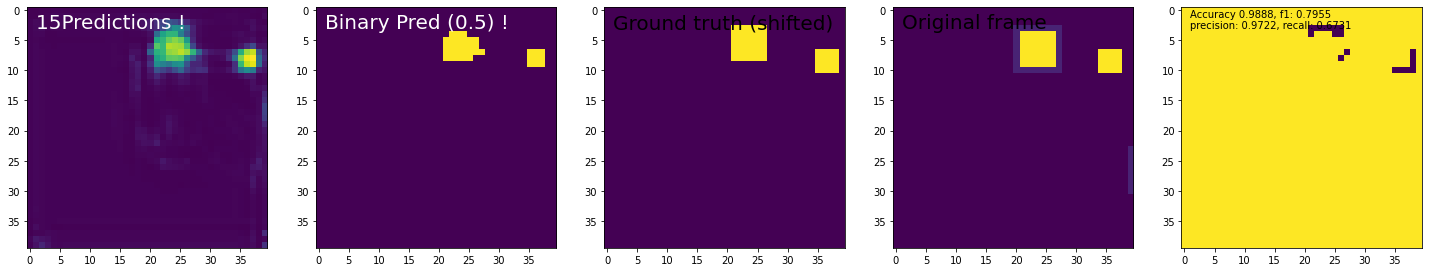

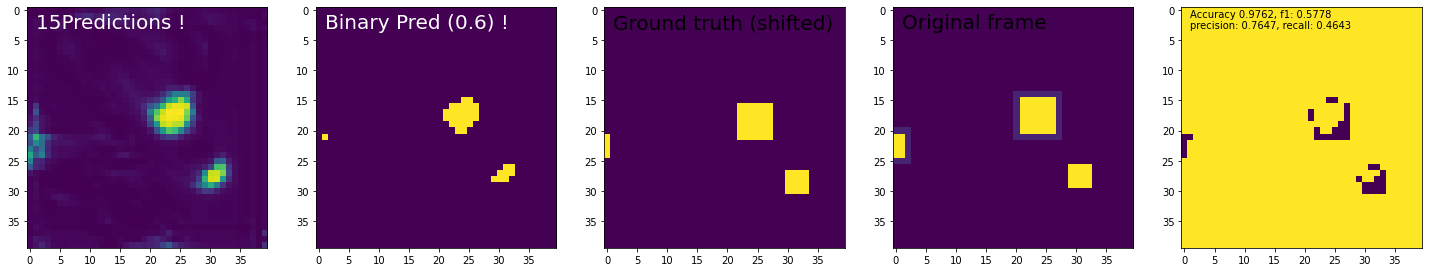

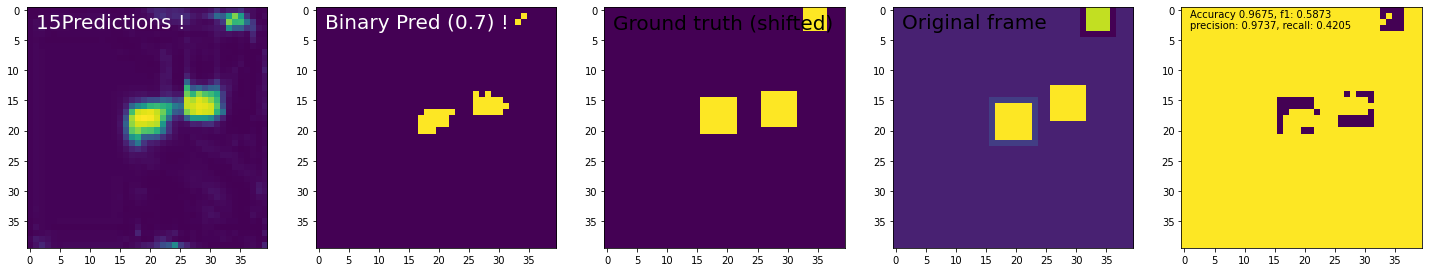

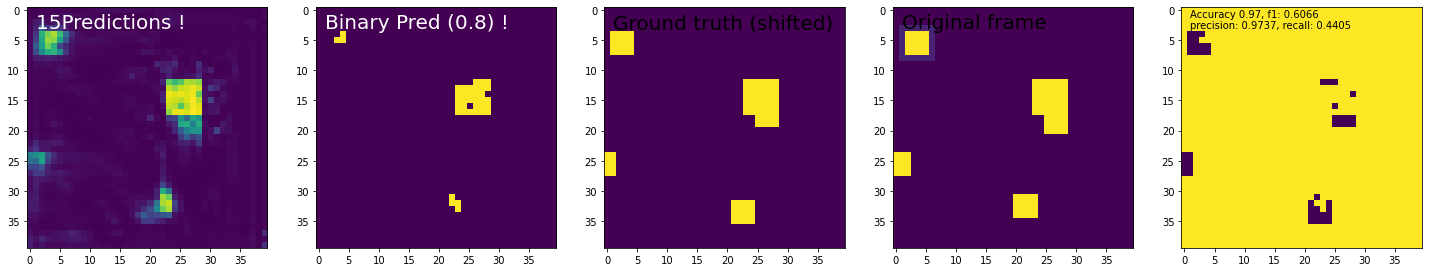

,n_frames,bin_threshold,f1
0,1,0.1,0.068567
1,1,0.2,NaN
2,1,0.3,NaN
3,1,0.4,NaN
4,1,0.5,NaN
...,...,...,...
115,15,0.4,0.807620
116,15,0.5,0.789520
117,15,0.6,0.713760
118,15,0.7,0.717980


In [ ]:
dfList_bin = []

plotIdx = np.random.randint(5)

for len_movie in range(1, 16):
  for bin_thr in np.arange(0.1, 0.9, 0.1):
    for execIdx in range(5):
      try:
        # print(len_movie, bin_thr, execIdx)
        noisy, shifted = generate_movies(n_samples=1, n_frames=len_movie)
        pred = seq.predict(noisy)
        plotCond = (len_movie % 3 == 0) and (execIdx == plotIdx)
        df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=plotCond, title=str(len_movie), binarize_threshold=bin_thr)
        if plotCond:
          plt.show()
        df.loc[:, 'n_frames'] = len_movie
        df.loc[:, 'idx'] = execIdx
        df.loc[:, 'bin_threshold'] = bin_thr
        dfList_bin.append(df)
      except Exception as e:
        print(f'Error with len {len_movie}, bin_thr {bin_thr}, execIdx {execIdx}')
        print(f'shape noisy {noisy.shape}, shape shifted {shifted.shape} and shape pred {pred.shape}')

perf_binDF = pd.concat(dfList_bin)
perf_binDF.groupby(['n_frames', 'bin_threshold'])['f1'].mean().reset_index()

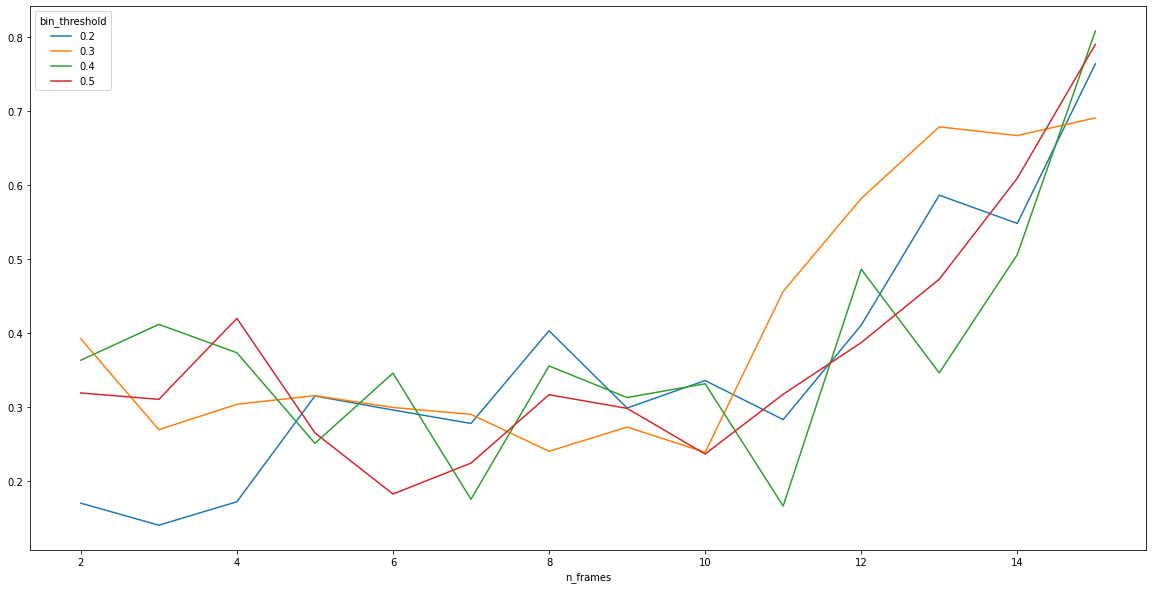

In [ ]:
df = pd.concat(dfList_bin).groupby(['n_frames', 'bin_threshold'])['f1'].mean().reset_index()
df = df.loc[(df.loc[:, 'bin_threshold']>=0.2)&(df.loc[:,'bin_threshold']<.6)]
piv = pd.pivot_table(df, columns='bin_threshold', index='n_frames', values='f1')
piv.rename(columns={k: str(round(k,1)) for k in piv.columns}).plot(figsize=(20,10))
plt.show()

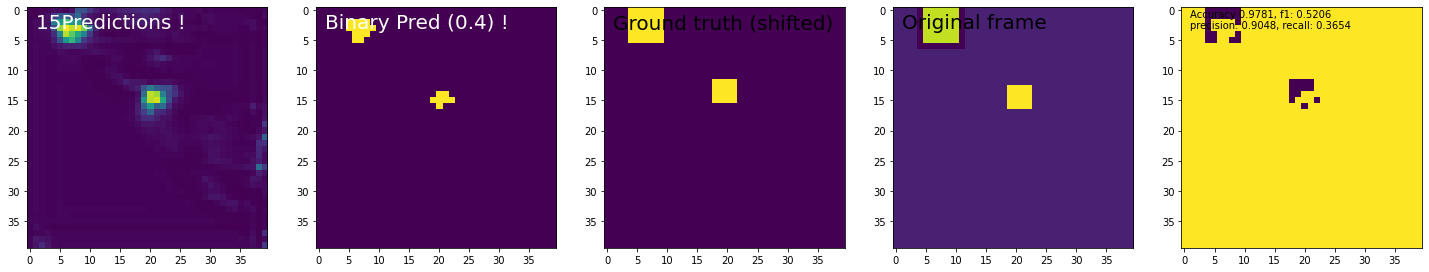

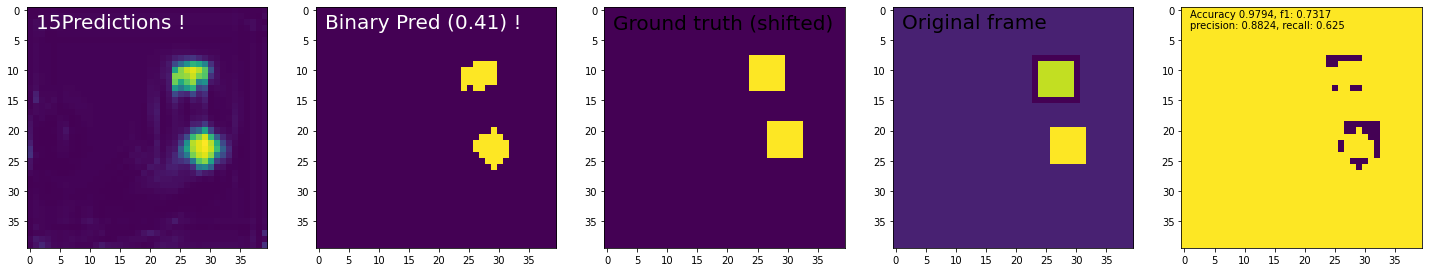

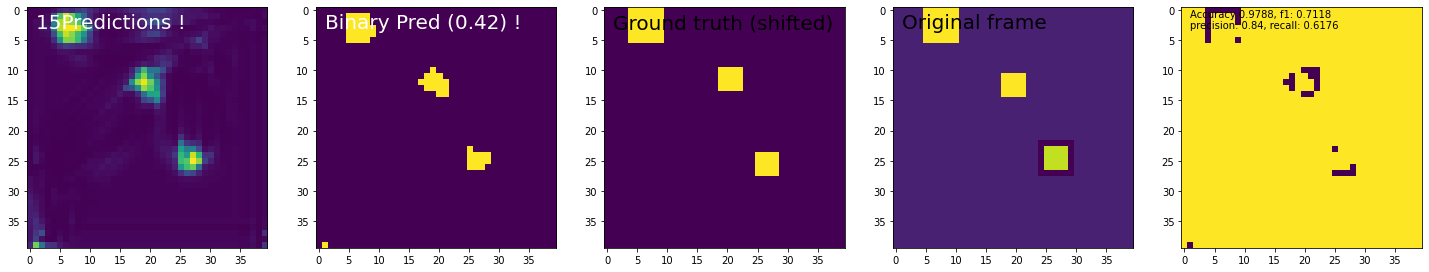

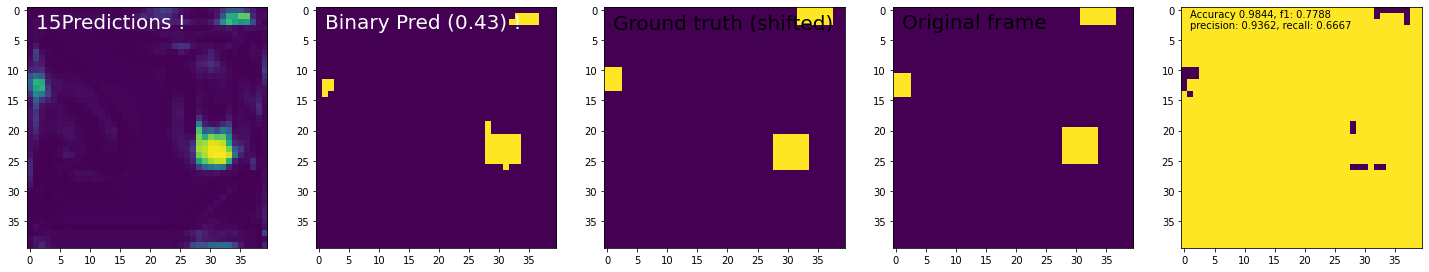

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


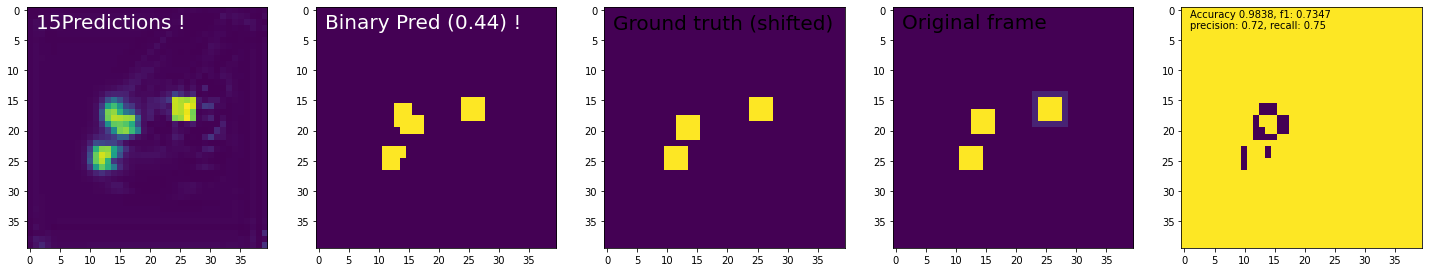

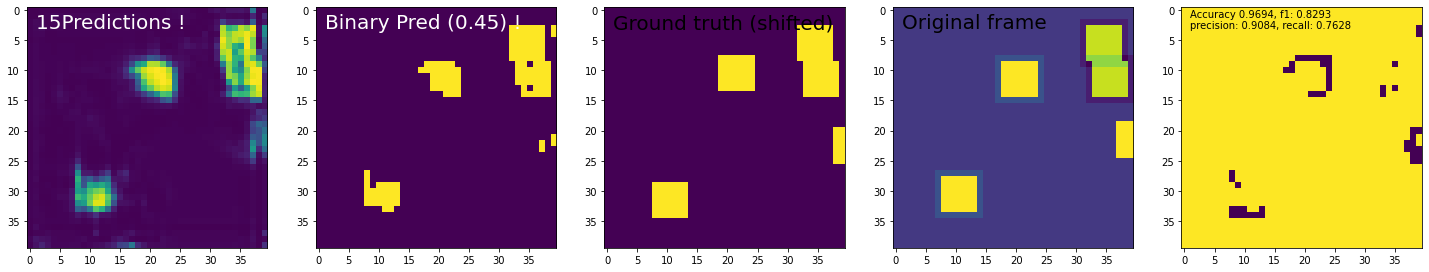

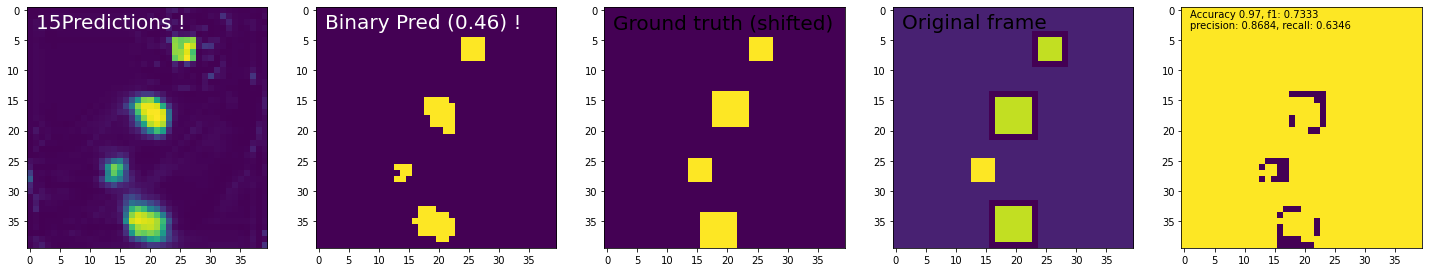

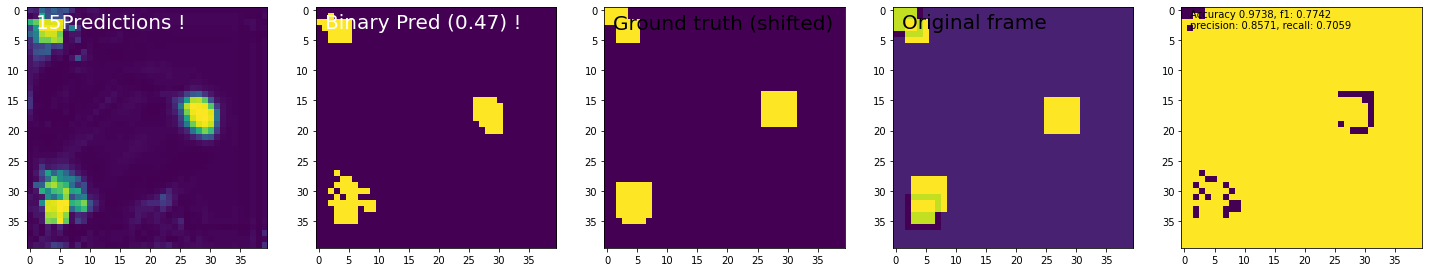

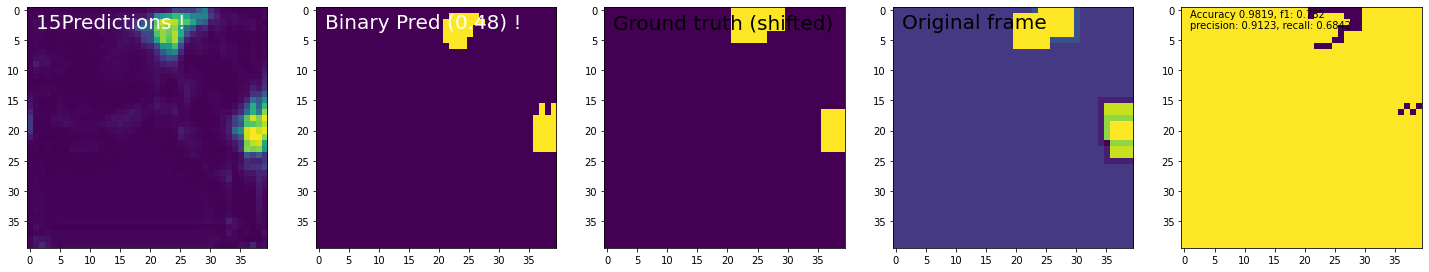

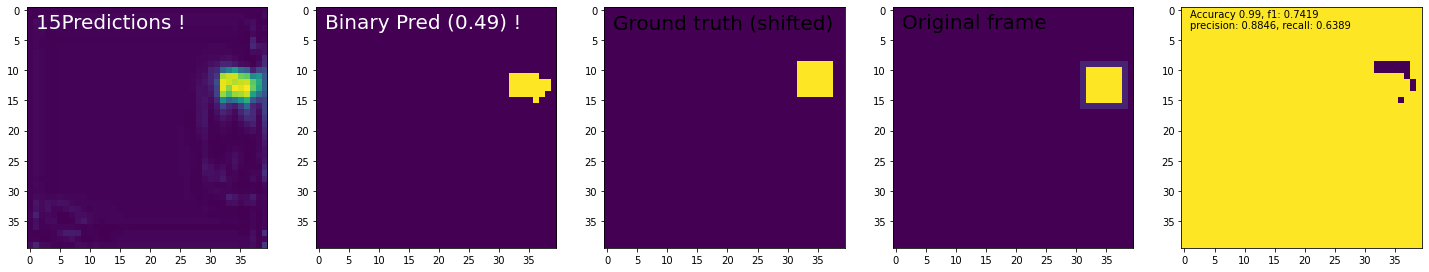

,n_frames,bin_threshold,f1
0,15,0.40,0.498840
1,15,0.41,0.650580
2,15,0.42,0.742740
3,15,0.43,0.708375
4,15,0.44,0.785840
5,15,0.45,0.649680
6,15,0.46,0.789660
7,15,0.47,0.773700
8,15,0.48,0.766100
9,15,0.49,0.718580


In [67]:
dfList_bin = []

lenMovie = 15
plotIdx = np.random.randint(5)

for binThr in np.arange(0.4, 0.5, 0.01):
  for execIdx in range(5):
    auxBinThr = round(binThr, 2)
    try:
      # print(lenMovie, auxBinThr, execIdx)
      noisy, shifted = generate_movies(n_samples=1, n_frames=lenMovie)
      pred = seq.predict(noisy)
      plotCond = (lenMovie % 3 == 0) and (execIdx == plotIdx)
      df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=plotCond, title=str(lenMovie), binarize_threshold=binThr)
      if plotCond:
        plt.show()
      df.loc[:, 'n_frames'] = lenMovie
      df.loc[:, 'idx'] = execIdx
      df.loc[:, 'bin_threshold'] = auxBinThr
      dfList_bin.append(df)
    except Exception as e:
      print(f'Error with len {lenMovie}, binThr {auxBinThr}, execIdx {execIdx}')
      print(f'shape noisy {noisy.shape}, shape shifted {shifted.shape} and shape pred {pred.shape}')

perf_binDF = pd.concat(dfList_bin)
perf_binDF.groupby(['n_frames', 'bin_threshold'])['f1'].mean().reset_index()

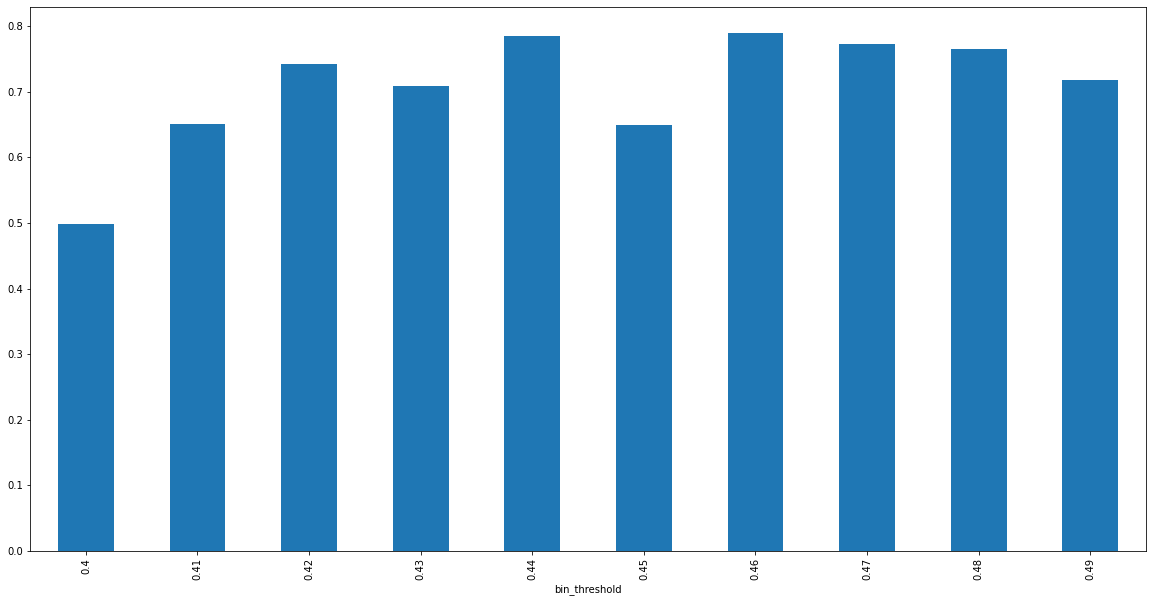

In [68]:
df = perf_binDF.copy()
df.loc[:, 'bin_threshold'] = df.loc[:, 'bin_threshold'].apply(lambda x: str(round(x, 2)))
df.groupby(['bin_threshold'])['f1'].mean().plot.bar(figsize=(20,10))
plt.show()

# Speed analysis

In [73]:
binThr

0.47463226

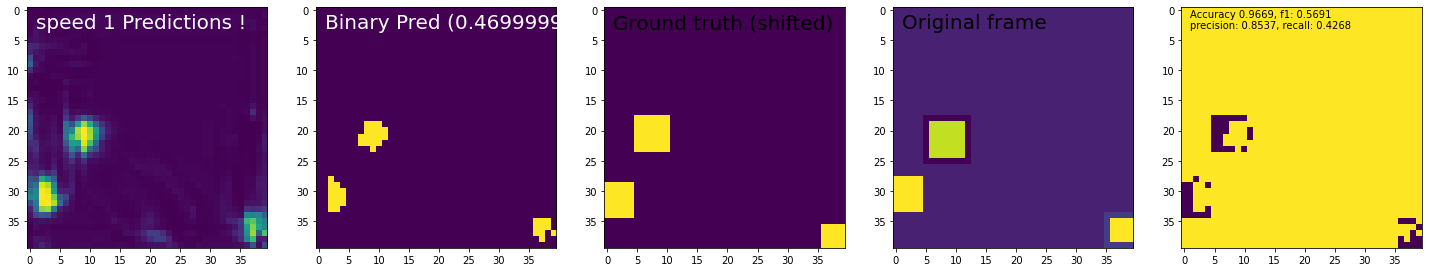

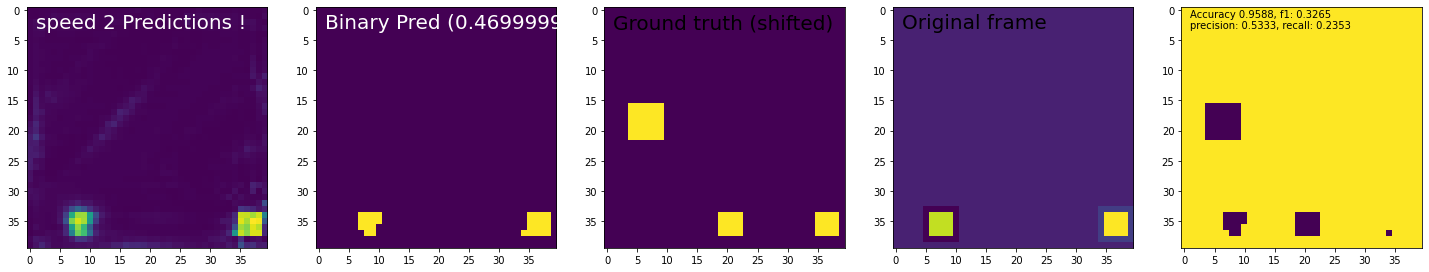

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


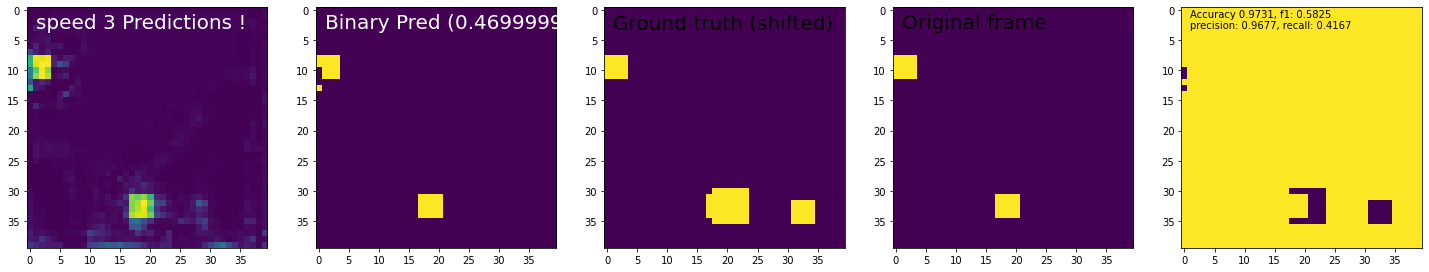

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


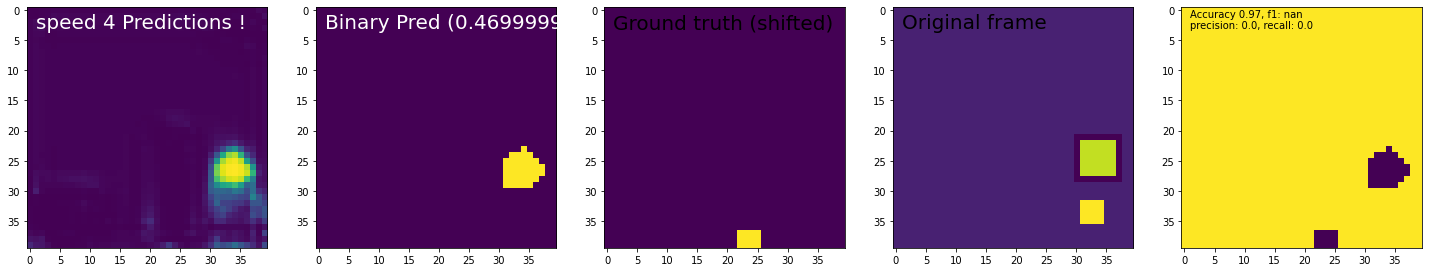

,n_frames,speed_rate,f1
0,15,1.0,0.717800
1,15,2.0,0.330700
2,15,3.0,0.474433
3,15,4.0,0.217400


In [77]:
dfList_speed = []

lenMovie = 15
plotIdx = np.random.randint(5)
binThr = threshold_otsu(pred15)

for speedRate in range(1, 5):
  for execIdx in range(5):
    auxBinThr = round(binThr, 2)
    try:
      # print(lenMovie, auxBinThr, execIdx)
      noisy, shifted = generate_movies(n_samples=1, n_frames=lenMovie, speed=speedRate)
      pred = seq.predict(noisy)
      plotCond = (lenMovie % 3 == 0) and (execIdx == plotIdx)
      df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=plotCond, title=f'speed {speedRate} ', binarize_threshold=auxBinThr)
      if plotCond:
        plt.show()
      df.loc[:, 'n_frames'] = lenMovie
      df.loc[:, 'idx'] = execIdx
      df.loc[:, 'speed_rate'] = speedRate
      dfList_speed.append(df)
    except Exception as e:
      print(e)
      print(f'Error with len {lenMovie}, execIdx {execIdx}')
      print(f'shape noisy {noisy.shape}, shape shifted {shifted.shape} and shape pred {pred.shape}')

perf_speedDF = pd.concat(dfList_speed)
perf_speedDF.groupby(['n_frames', 'speed_rate'])['f1'].mean().reset_index()

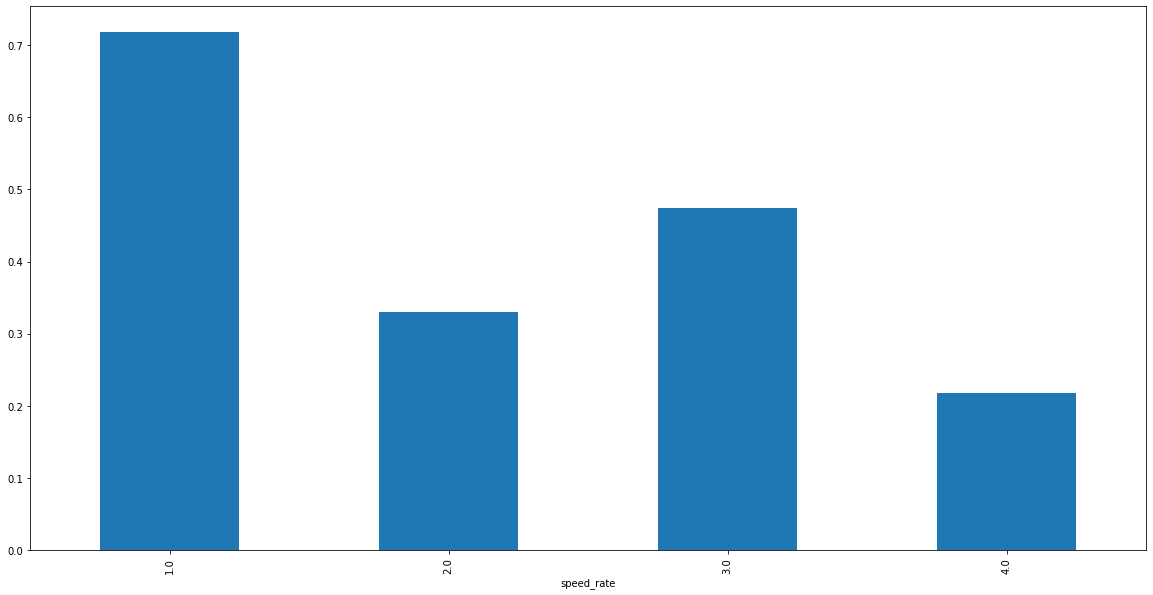

In [78]:
df = perf_speedDF.copy()
df.groupby(['speed_rate'])['f1'].mean().plot.bar(figsize=(20,10))
plt.show()

# Noise analysis

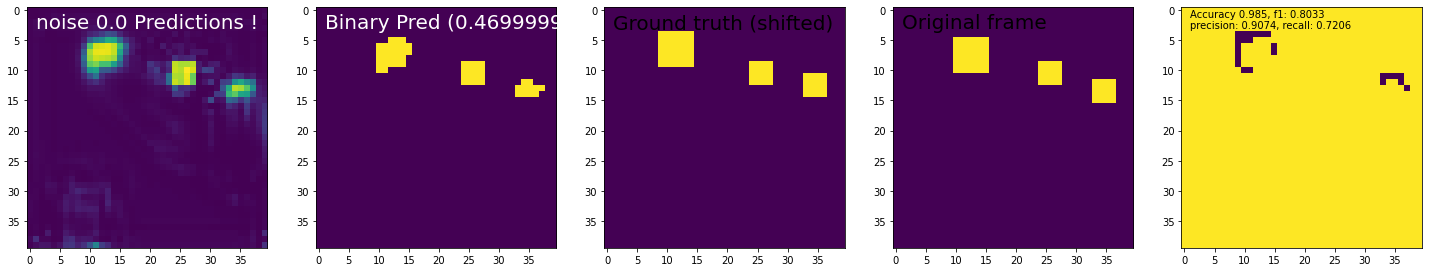

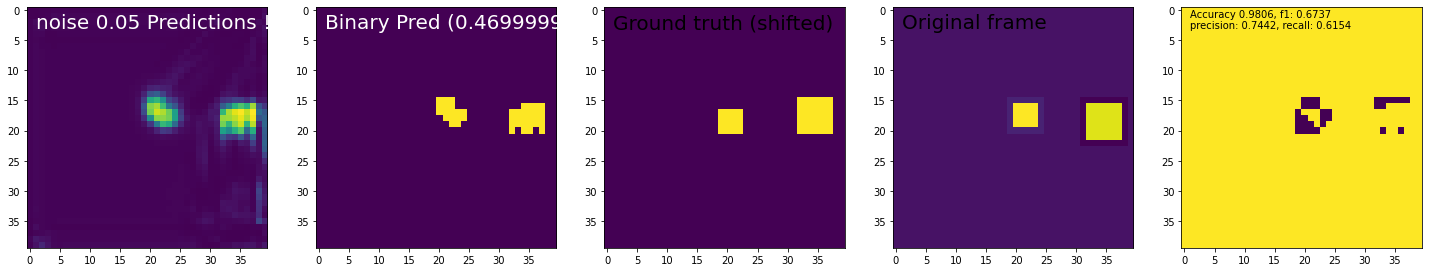

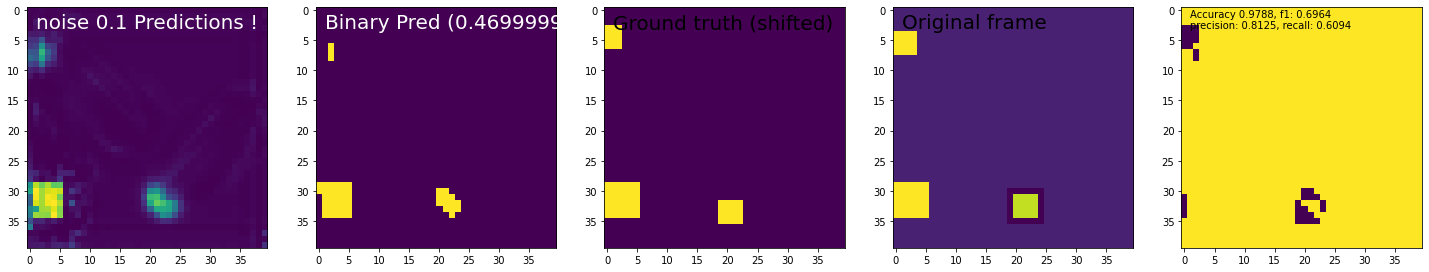

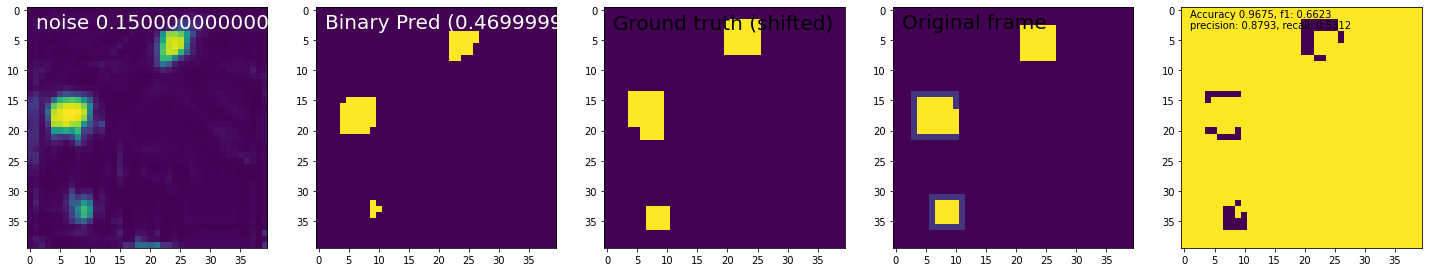

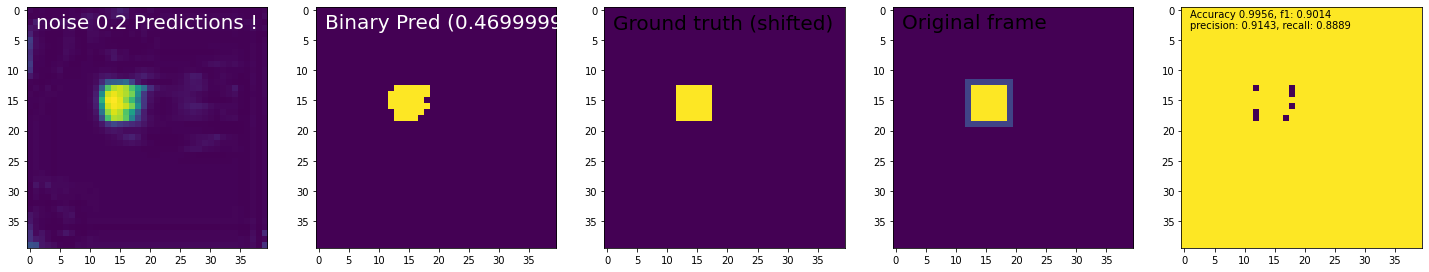

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


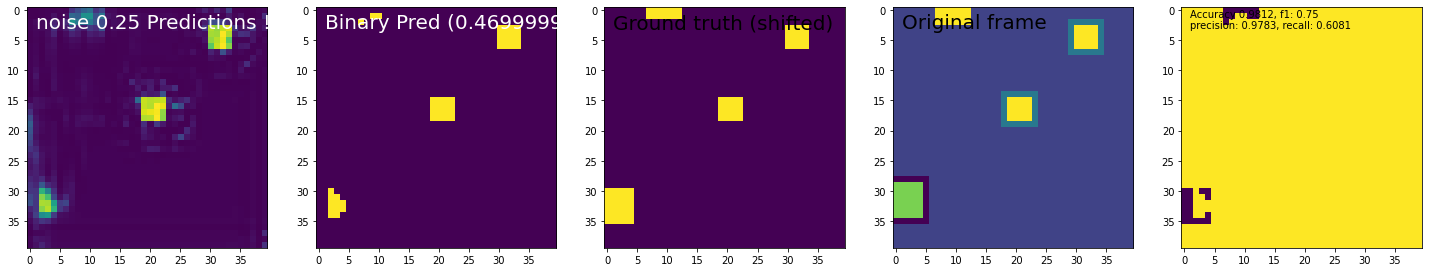

Shape of passed values is (1, 1), indices imply (2, 2)
Error with len 15, execIdx 4
shape noisy (1, 15, 40, 40, 1), shape shifted (1, 15, 40, 40, 1) and shape pred (1, 15, 40, 40, 1)


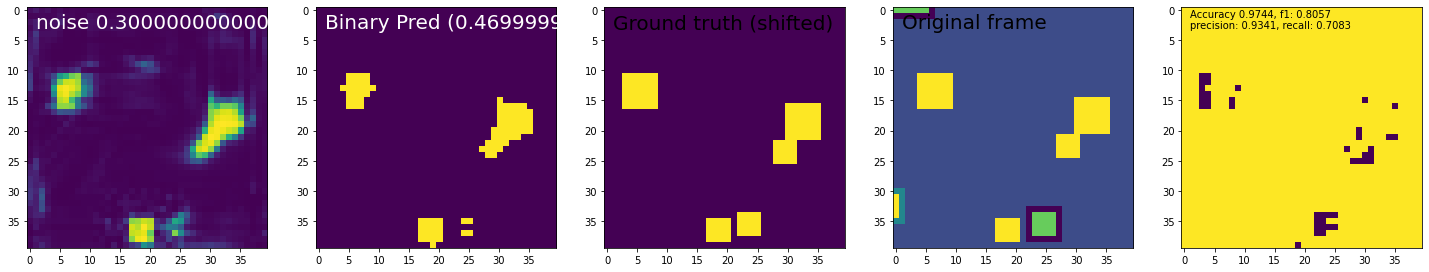

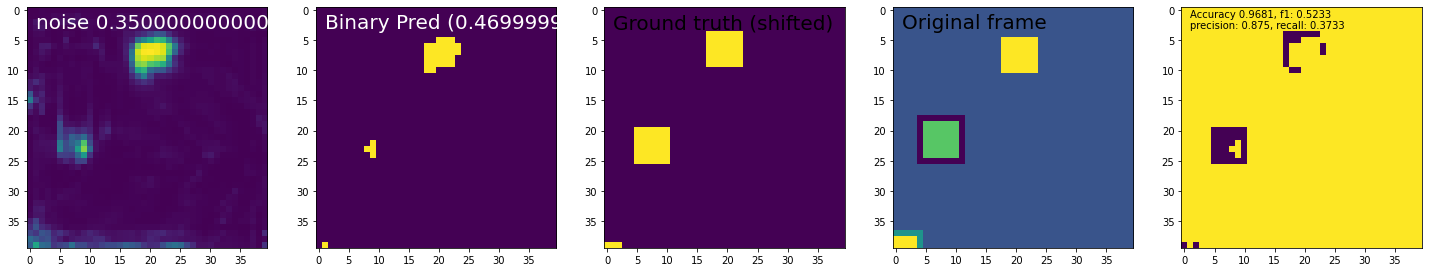

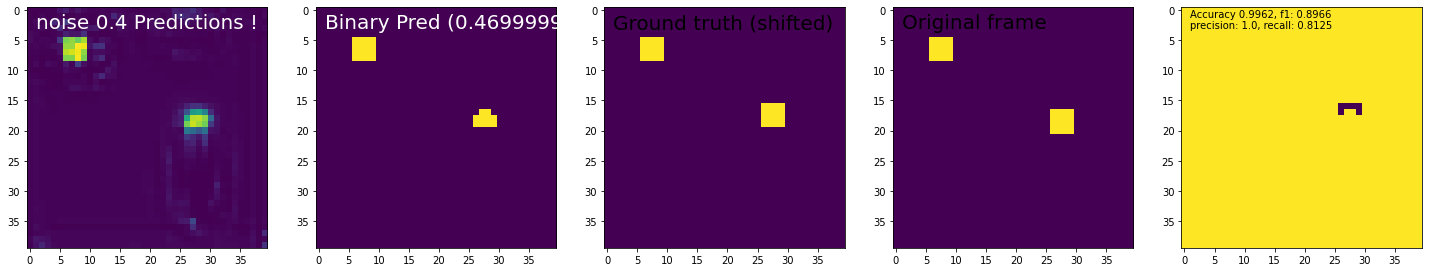

Shape of passed values is (1, 1), indices imply (2, 2)
Error with len 15, execIdx 0
shape noisy (1, 15, 40, 40, 1), shape shifted (1, 15, 40, 40, 1) and shape pred (1, 15, 40, 40, 1)


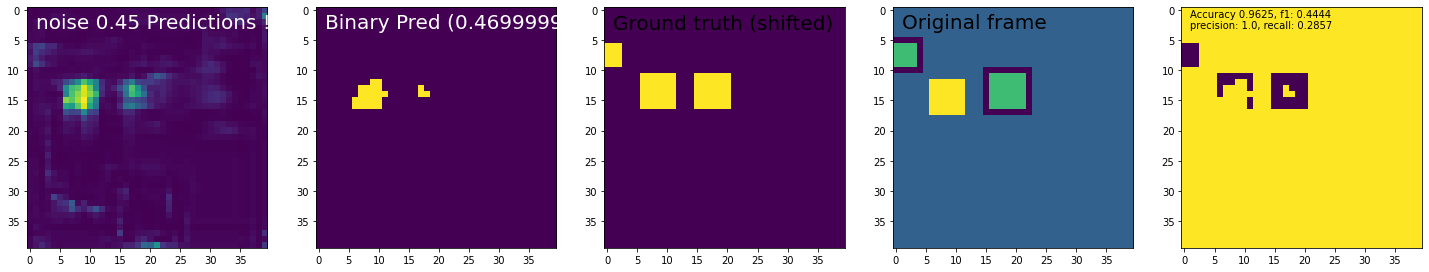

,n_frames,noise,f1
0,15,0.00,0.753460
1,15,0.05,0.681960
2,15,0.10,0.814780
3,15,0.15,0.783200
4,15,0.20,0.789360
5,15,0.25,0.723567
6,15,0.30,0.692640
7,15,0.35,0.705380
8,15,0.40,0.755700
9,15,0.45,0.402575


In [86]:
dfList_speed = []

lenMovie = 15
plotIdx = np.random.randint(5)
binThr = threshold_otsu(pred15)

for noise in np.arange(0.0, 0.5, 0.05):
  for execIdx in range(5):
    auxBinThr = round(binThr, 2)
    try:
      # print(lenMovie, auxBinThr, execIdx)
      noisy, shifted = generate_movies(n_samples=1, n_frames=lenMovie, noise=noise)
      pred = seq.predict(noisy)
      plotCond = (lenMovie % 3 == 0) and (execIdx == plotIdx)
      df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=plotCond, title=f'noise {noise} ', binarize_threshold=auxBinThr)
      if plotCond:
        plt.show()
      df.loc[:, 'n_frames'] = lenMovie
      df.loc[:, 'idx'] = execIdx
      df.loc[:, 'noise'] = noise
      dfList_speed.append(df)
    except Exception as e:
      print(e)
      print(f'Error with len {lenMovie}, execIdx {execIdx}')
      print(f'shape noisy {noisy.shape}, shape shifted {shifted.shape} and shape pred {pred.shape}')

perf_speedDF = pd.concat(dfList_speed)
perf_speedDF.groupby(['n_frames', 'noise'])['f1'].mean().reset_index()

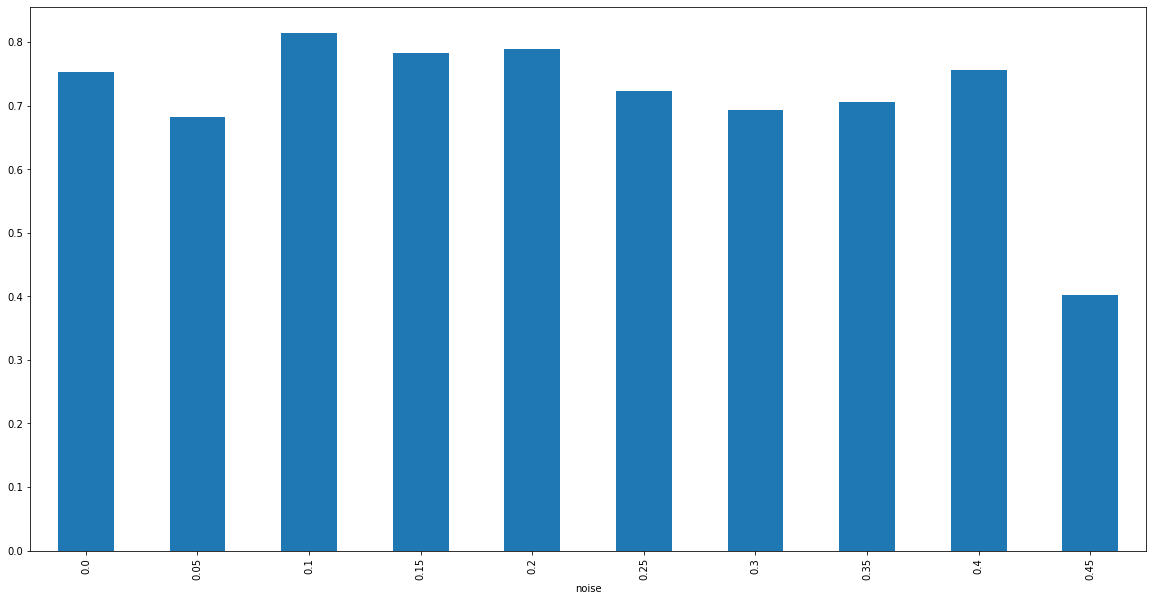

In [87]:
df = perf_speedDF.copy()
df.loc[:, 'noise'] = df.loc[:, 'noise'].apply(lambda x: str(round(x, 2)))
df.groupby(['noise'])['f1'].mean().plot.bar(figsize=(20,10))
plt.show()